# Importing libraries
### Done by Gabriel, Colby, Heejun

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import gc
# import preprocessing classes
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# feature selection
from sklearn.feature_selection import chi2, mutual_info_regression
from sklearn.feature_selection import SelectKBest, chi2

# import models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# import train test split
from sklearn.model_selection import train_test_split

# feature importance
from sklearn.inspection import permutation_importance

# import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# functions to save data
from joblib import dump, load

# read data
## mount google drive
from google.colab import drive
drive.mount("/content/drive/")
%cd '/content/drive/MyDrive/DS440/dataset/Data/'
!pwd

## read in files
dir = '/content/drive/MyDrive/DS440/dataset/Data/'
cnx = sqlite3.connect(dir + 'wildfire.sqlite')
cursor = cnx.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='Fires';")
tables = cursor.fetchall()
Fires = pd.read_sql_query("SELECT * FROM 'Fires'", cnx).set_index('FOD_ID')
gc.collect()
# Drop unnecessary column
Fires.drop(columns=['FPA_ID','SOURCE_SYSTEM_TYPE','SOURCE_SYSTEM','NWCG_REPORTING_AGENCY','NWCG_REPORTING_UNIT_ID',
                    'NWCG_REPORTING_UNIT_NAME','SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',
                    'LOCAL_INCIDENT_ID','FIRE_CODE','FIRE_NAME','ICS_209_PLUS_INCIDENT_JOIN_ID','ICS_209_PLUS_COMPLEX_JOIN_ID',
                    'MTBS_ID','MTBS_FIRE_NAME','COMPLEX_NAME','OWNER_DESCR','NWCG_CAUSE_CLASSIFICATION',
                    'NWCG_CAUSE_AGE_CATEGORY','CONT_TIME','CONT_DATE'],inplace=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/DS440/dataset/Data
/content/drive/MyDrive/DS440/dataset/Data


In [ ]:
Fires.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
FOD_ID,,,,,,,,,,,,,,
1,2005,2/2/2005 0:00,33,1300.0,Power generation/transmission/distribution,33.0,0.10,A,40.036944,-121.005833,CA,63,06063,Plumas County
2,2004,5/12/2004 0:00,133,845.0,Natural,133.0,0.25,A,38.933056,-120.404444,CA,61,06061,Placer County
3,2004,5/31/2004 0:00,152,1921.0,Debris and open burning,152.0,0.10,A,38.984167,-120.735556,CA,17,06017,El Dorado County
4,2004,6/28/2004 0:00,180,1600.0,Natural,185.0,0.10,A,38.559167,-119.913333,CA,3,06003,Alpine County
5,2004,6/28/2004 0:00,180,1600.0,Natural,185.0,0.10,A,38.559167,-119.933056,CA,3,06003,Alpine County


In [ ]:
pd.DataFrame(Fires.groupby('FIRE_SIZE_CLASS').count())

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
FIRE_SIZE_CLASS,,,,,,,,,,,,,
A,810694,810694,810694,601523,810694,558359,810694,810694,810694,810694,562207,562207,562207
B,1047772,1047772,1047772,617474,1047772,571098,1047772,1047772,1047772,1047772,735656,735656,735656
C,246247,246247,246247,147740,246247,139868,246247,246247,246247,246247,171769,171769,171769
D,32261,32261,32261,21750,32261,20582,32261,32261,32261,32261,21491,21491,21491
E,16227,16227,16227,12118,16227,11426,16227,16227,16227,16227,10276,10276,10276
F,9097,9097,9097,7589,9097,7035,9097,9097,9097,9097,5552,5552,5551
G,4455,4455,4455,4091,4455,3832,4455,4455,4455,4455,2567,2567,2567


# Data Preprocessing
## convert all features into usable format
## Use random sample from originial dataset due to high computational cost
## Take 5% of original data
## Purpose : 
1. To handle big data
2. To debug and to see that the code actually works

In [ ]:
Fires_A = Fires[Fires['FIRE_SIZE_CLASS'] == 'A'].sample(frac=0.01,replace=False)
Fires_B = Fires[Fires['FIRE_SIZE_CLASS'] == 'B'].sample(frac=0.01,replace=False)
Fires_C = Fires[Fires['FIRE_SIZE_CLASS'] == 'C'].sample(frac=0.01,replace=False)
Fires_D = Fires[Fires['FIRE_SIZE_CLASS'] == 'D'].sample(frac=0.01,replace=False)
Fires_E = Fires[Fires['FIRE_SIZE_CLASS'] == 'E'].sample(frac=0.01,replace=False)
Fires_F = Fires[Fires['FIRE_SIZE_CLASS'] == 'F'].sample(frac=0.01,replace=False)
Fires_G = Fires[Fires['FIRE_SIZE_CLASS'] == 'G'].sample(frac=0.01,replace=False)
Fires_AB = pd.concat([Fires_A, Fires_B], ignore_index=True)
Fires_CD = pd.concat([Fires_C, Fires_D], ignore_index=True)
Fires_EF = pd.concat([Fires_E, Fires_F], ignore_index=True)
Fires_EFG = pd.concat([Fires_EF, Fires_G], ignore_index=True)
Fires_ABCD = pd.concat([Fires_AB, Fires_CD], ignore_index=True)
Fires = pd.concat([Fires_ABCD, Fires_EFG], ignore_index=True)
Fires

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,2012,7/6/2012 0:00,188,828.0,Natural,188.0,0.1,A,38.140300,-108.222060,CO,San Miguel,08113,San Miguel County
1,2008,5/3/2008 0:00,124,1624.0,Missing data/not specified/undetermined,NaN,0.1,A,34.470512,-117.349732,CA,SAN BERNARDINO,06071,San Bernardino County
2,1995,8/4/1995 0:00,216,1529.0,Natural,216.0,0.1,A,39.900000,-108.134000,CO,None,None,None
3,1995,2/27/1995 0:00,58,NaN,Railroad operations and maintenance,NaN,0.1,A,29.190000,-82.340000,FL,Marion,12083,Marion County
4,2009,9/1/2009 0:00,244,1554.0,Equipment and vehicle use,244.0,0.1,A,48.198100,-119.687500,WA,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21663,2000,5/7/2000 0:00,128,1515.0,Missing data/not specified/undetermined,151.0,6518.0,G,33.350278,-105.633889,NM,None,None,None
21664,1994,4/7/1994 0:00,97,1901.0,Natural,212.0,6000.0,G,33.818333,-107.598333,NM,None,None,None
21665,2011,4/16/2011 0:00,106,1308.0,Missing data/not specified/undetermined,117.0,7091.0,G,30.532500,-94.302800,TX,None,None,None
21666,2005,11/12/2005 0:00,316,1525.0,Missing data/not specified/undetermined,327.0,5300.0,G,31.138333,-89.112500,MS,111,28111,Perry County


# Colby's Coding

In [ ]:
# extract month from discovery date
def get_first_element(date_list):
  return date_list[0]

Fires['DISCOVERY_DATE'] = Fires['DISCOVERY_DATE'].astype("string")
Fires['DISCOVERY_LIST'] = Fires['DISCOVERY_DATE'].str.split(pat='/')
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_LIST'].map(get_first_element)
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_MONTH'].astype("int64")

# encode causes into integers
Fires['NWCG_GENERAL_CAUSE'] = Fires['NWCG_GENERAL_CAUSE'].astype("string")
cause_enc = LabelEncoder()
Fires['NWCG_CAUSE_CLASSIFICATION_ORD'] = cause_enc.fit_transform(Fires['NWCG_GENERAL_CAUSE'])


# figure out number of days to contain the fire
Fires['DAYS_TO_CONT'] = Fires['CONT_DOY'] - Fires['DISCOVERY_DOY']
##### if it was contained the next year, need to do something about that
def convert_negative_days(day):
  if day < 0:
    return 365 + day
  else:
    return day

Fires['DAYS_TO_CONT'] = Fires['DAYS_TO_CONT'].map(convert_negative_days)


# encode state categories into integers
Fires['STATE'] = Fires['STATE'].astype("string")
state_enc = LabelEncoder()
Fires['STATE_ORD'] = state_enc.fit_transform(Fires['STATE'])

# what to do about counties? Use fips code (must be an int)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("string")
Fires['FIPS_CODE'].fillna('1000000',inplace=True)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("int64")

# fill NA with mean of day to containment (mean = 0.92)
Fires['DAYS_TO_CONT'].fillna(value=Fires['DAYS_TO_CONT'].mean(),inplace=True)


# drop date and list
Fires.drop(columns=['DISCOVERY_DATE','DISCOVERY_LIST','NWCG_GENERAL_CAUSE',
                    'CONT_DOY','DISCOVERY_DOY','STATE','FIPS_NAME',
                    'COUNTY'],inplace=True)
gc.collect()

19

In [ ]:
Fires.head()

,FIRE_YEAR,DISCOVERY_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD
0,2012,828.0,0.1,A,38.140300,-108.222060,8113,7,7,0.000000,5
1,2008,1624.0,0.1,A,34.470512,-117.349732,6071,5,5,0.895784,4
2,1995,1529.0,0.1,A,39.900000,-108.134000,1000000,8,7,0.000000,5
3,1995,NaN,0.1,A,29.190000,-82.340000,12083,2,10,0.895784,8
4,2009,1554.0,0.1,A,48.198100,-119.687500,1000000,9,2,0.000000,47


In [ ]:
#Replace NaN with values predicted by KNN
from sklearn.impute import KNNImputer
Fires_KNN = Fires.sample(frac=1,random_state=0)
Input = Fires_KNN[['FIRE_YEAR','DISCOVERY_TIME','FIRE_SIZE','LATITUDE','LONGITUDE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD']]
imputer = KNNImputer(n_neighbors=10)

In [ ]:
result = imputer.fit_transform(Input)
check = pd.DataFrame(result)
New_Discovery_Time = check[[1]].values.tolist()

In [ ]:
Fires_KNN['Assumption'] = New_Discovery_Time
# Convert object to float64
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].astype("string")
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].str.strip('[]')
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].astype("float64")
# Drop DISCOVERY_TIME column that contains NaN
Fires_KNN.drop(columns=['DISCOVERY_TIME'],inplace=True)
# Change column name from Assumption to DISCOVERY_TIME
Fires_KNN['DISCOVERY_TIME'] = Fires_KNN['Assumption']
Fires_KNN.drop(columns=['Assumption'],inplace=True)
Fires_KNN

,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD,DISCOVERY_TIME
14327,2017,1.00,B,33.006750,-95.067640,48063,3,1,0.895784,43,1301.1
14842,2006,8.00,B,29.863890,-83.384990,12123,5,7,0.000000,8,1420.0
2743,2017,0.15,A,32.084894,-82.174761,13267,3,0,0.000000,9,1527.0
10697,2003,3.05,B,32.942959,-81.795772,13033,1,0,0.895784,9,1238.5
19868,1995,26.00,C,32.795749,-89.616802,28079,4,0,0.000000,24,1410.0
...,...,...,...,...,...,...,...,...,...,...,...
13123,2011,1.50,B,29.773500,-81.721800,12107,4,9,0.000000,8,1200.0
19648,1999,20.00,C,37.757500,-83.623100,1000000,8,7,0.895784,16,1468.0
9845,1993,4.00,B,33.887500,-80.825000,45079,9,5,0.000000,40,1685.5
10799,2015,0.88,B,42.644000,-73.749300,36001,8,5,0.000000,33,729.0


# ** Code by Heejun **
## Feature selection information
Later need to convert LONGITUDE to negative values!!

Reason for using abs() : There are no positive values !!
                        
(United States only have negative lonitude values)

In [ ]:
# Convert negative value to positive
# Feature Selection must have non-negative values
Fires_KNN['LONGITUDE'] = Fires_KNN['LONGITUDE'].abs()

from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing

X_KNN = Fires_KNN[['FIRE_YEAR','LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y_KNN = Fires_KNN['FIRE_SIZE']
# Transform FIRE_SIZE
# SelectKBest() cannot handle countinous numbers
Encoder_KNN = preprocessing.LabelEncoder()
Firs_size_encoded_KNN = Encoder_KNN.fit_transform(y_KNN)

Best_Features_KNN = dict()
for i in range(1,9):
  selector_KNN = SelectKBest(chi2, k=i)
  selector_KNN.fit(X_KNN, Firs_size_encoded_KNN)
  Features_KNN = list(X_KNN.columns[selector_KNN.get_support(indices=True)])
  Best_Features_KNN[i] = Features_KNN
  print("(KNN) When k= ", i, ",", Features_KNN)

(KNN) When k=  1 , ['FIPS_CODE']
(KNN) When k=  2 , ['FIPS_CODE', 'DAYS_TO_CONT']
(KNN) When k=  3 , ['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME']
(KNN) When k=  4 , ['FIPS_CODE', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  5 , ['LONGITUDE', 'FIPS_CODE', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  6 , ['LONGITUDE', 'FIPS_CODE', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  7 , ['LATITUDE', 'LONGITUDE', 'FIPS_CODE', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  8 , ['LATITUDE', 'LONGITUDE', 'FIPS_CODE', 'DISCOVERY_MONTH', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']


# With missing values(NaN), models cannot be trained!

Below code will show the error!

In [ ]:
#### split data into training, validation, and testing
X = Fires[['FIRE_YEAR','LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y = Fires['FIRE_SIZE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#### List of models
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR] #GaussianNB, 
################################################################################################################################               
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print("MSE = ", model_mse, '\n', "MAE = ", model_mae)

<class 'sklearn.linear_model._base.LinearRegression'>


ValueError: ignored

# MODEL

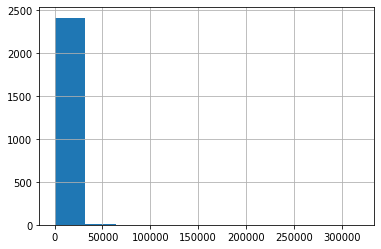

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'] >= 15]['FIRE_SIZE'].hist()

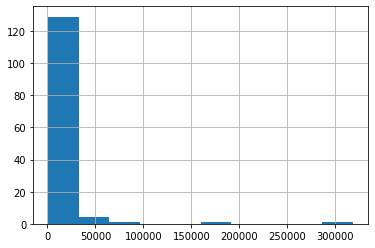

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'] >= 1000]['FIRE_SIZE'].hist()

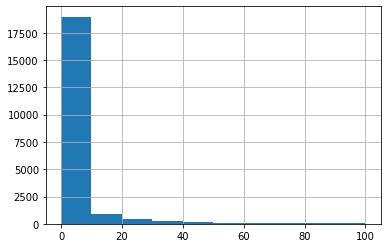

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(0,100)]['FIRE_SIZE'].hist()

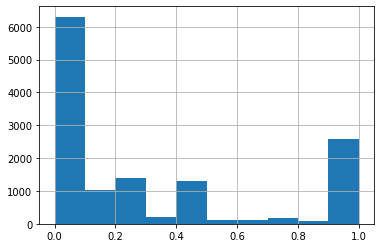

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(0,1)]['FIRE_SIZE'].hist()

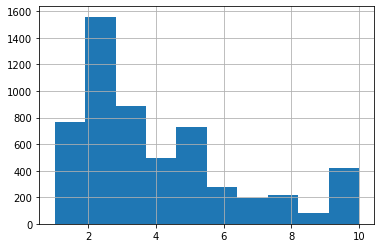

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(1.01,10)]['FIRE_SIZE'].hist()

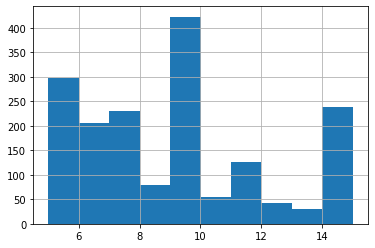

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(5.01,15)]['FIRE_SIZE'].hist()

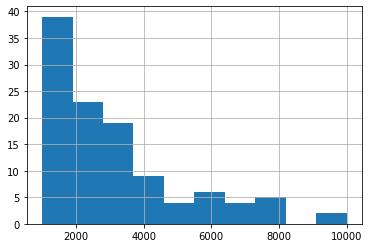

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(1000,10000)]['FIRE_SIZE'].hist()

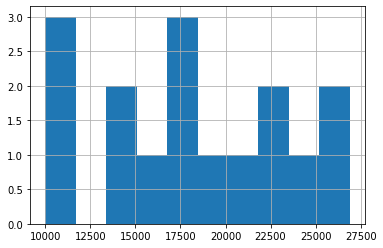

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(10000,30000)]['FIRE_SIZE'].hist()

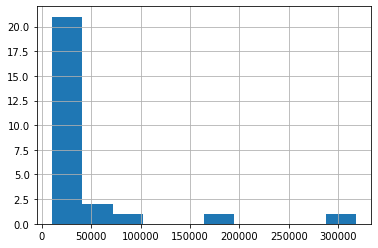

In [ ]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(10000,333330000)]['FIRE_SIZE'].hist()

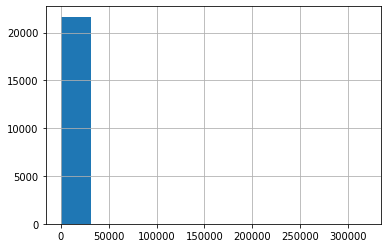

In [ ]:
Fires['FIRE_SIZE'].hist()

# Trial 1
  - Use all data to predict fire size

## Create the baseline
 - Use all the data to predict fire size in year 2018

In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.551512e+04,28.940856
0,<class 'sklearn.linear_model._base.LinearRegre...,3.452255e+05,129.140020
1,<class 'sklearn.ensemble._forest.RandomForestR...,4.039467e+05,105.428749
2,<class 'sklearn.neighbors._regression.KNeighbo...,4.391250e+05,65.704108
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,7.973650e+05,126.269993
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.411111e+06,766.819095


## Use ensemble method

In [ ]:
from sklearn.ensemble import VotingRegressor
# Models
r1_t1 = LinearRegression()
r2_t1 = RandomForestRegressor()
r3_t1 = GradientBoostingRegressor()
r4_t1 = AdaBoostRegressor()
r5_t1 = KNeighborsRegressor()
r6_t1 = SVR()
# Possible ensembles
est_t1c1=[('reg1', r1_t1), ('reg2', r2_t1)]
est_t1c2=[('reg1', r1_t1), ('reg3', r3_t1)]
est_t1c3=[('reg1', r1_t1), ('reg4', r4_t1)]
est_t1c4=[('reg1', r1_t1), ('reg5', r5_t1)]
est_t1c5=[('reg1', r1_t1), ('reg6', r6_t1)]
est_t1c6=[('reg2', r2_t1), ('reg3', r3_t1)]
est_t1c7=[('reg2', r2_t1), ('reg4', r4_t1)]
est_t1c8=[('reg2', r2_t1), ('reg5', r5_t1)]
est_t1c9=[('reg2', r2_t1), ('reg6', r6_t1)]
est_t1c10=[('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c11=[('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c12=[('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c13=[('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c14=[('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c15=[('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c16=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1)]
est_t1c17=[('reg1', r1_t1), ('reg2', r2_t1), ('reg4', r4_t1)]
est_t1c18=[('reg1', r1_t1), ('reg2', r2_t1), ('reg5', r5_t1)]
est_t1c19=[('reg1', r1_t1), ('reg2', r2_t1), ('reg6', r6_t1)]
est_t1c20=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c21=[('reg1', r1_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c22=[('reg1', r1_t1), ('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c23=[('reg1', r1_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c24=[('reg1', r1_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c25=[('reg1', r1_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c26=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c27=[('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c28=[('reg2', r2_t1), ('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c29=[('reg2', r2_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c30=[('reg2', r2_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c31=[('reg2', r2_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c32=[('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c33=[('reg3', r3_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c34=[('reg3', r3_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c35=[('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c36=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c37=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c38=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c39=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c40=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c41=[('reg1', r1_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c42=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c43=[('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c44=[('reg2', r2_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c45=[('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c46=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c47=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c48=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c49=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c50=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
ens_list = [est_t1c1,est_t1c2,est_t1c3,est_t1c4,est_t1c5,est_t1c6,est_t1c7,est_t1c8,est_t1c9,est_t1c10,
            est_t1c11,est_t1c12,est_t1c13,est_t1c14,est_t1c15,est_t1c16,est_t1c17,est_t1c18,est_t1c19,est_t1c20,
            est_t1c21,est_t1c22,est_t1c23,est_t1c24,est_t1c25,est_t1c26,est_t1c27,est_t1c28,est_t1c29,est_t1c30,
            est_t1c31,est_t1c32,est_t1c33,est_t1c34,est_t1c35,est_t1c36,est_t1c37,est_t1c38,est_t1c39,est_t1c40,
            est_t1c41,est_t1c42,est_t1c43,est_t1c44,est_t1c45,est_t1c46,est_t1c47,est_t1c48,est_t1c49,est_t1c50]

model_ens_t1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t1 = VotingRegressor(i).fit(X_KNN_train,X_KNN_test)
  # Predict with our ensemble model
  ensemble_t1_pred = ensemble_t1.predict(y_KNN_train)
  model_ens_t1_mse = mean_squared_error(ensemble_t1_pred,y_KNN_test)
  model_ens_t1_mae = mean_absolute_error(ensemble_t1_pred,y_KNN_test)
  model_scores_ens_t1 = (ensemble_t1,y_KNN_test,ensemble_t1_pred)
  model_ens_t1_df = model_ens_t1_df.append({'Model':i,'MSE':model_ens_t1_mse,'MAE':model_ens_t1_mae}, ignore_index=True)
  model_ens_t1_df = model_ens_t1_df.sort_values(by='MSE', ascending= True)
model_ens_t1_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",151659.808601,76.806567
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",158538.787275,70.997647
2,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",159415.097694,61.429836
3,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",180841.177480,46.144582
4,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",188929.465960,215.081836


In [ ]:
model_ens_t1_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

In [ ]:
model_ens_t1_df['Model'][1]

[('reg1', LinearRegression()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t1_df['Model'][2]

[('reg2', RandomForestRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t1_df['Model'][3]

[('reg5', KNeighborsRegressor()), ('reg6', SVR())]

In [ ]:
model_ens_t1_df['Model'][4]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor()), ('reg6', SVR())]

# Trial 2 (Divide dataset by fire size)
  - Division number: 10

- 1st Division (Fire Size < 1)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 1st Division (Fire Size < 1)
Fires_t2_div1 = Fires_KNN[Fires_KNN['FIRE_SIZE'] <= 1]
XT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d1 = dict()       
model_T2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d1 = model().fit(XT2d1_train,XT2d1_test)
  y_T2d1_pred = regressor_T2d1.predict(yT2d1_train)
  model_T2d1_mse = mean_squared_error(y_T2d1_pred,yT2d1_test)
  model_T2d1_mae = mean_absolute_error(y_T2d1_pred,yT2d1_test)
  model_scores_T2d1[model] = (regressor_T2d1,yT2d1_test,y_T2d1_pred)
  model_T2d1_df = model_T2d1_df.append({'Model':model,'MSE':model_T2d1_mse,'MAE':model_T2d1_mae}, ignore_index=True)
  model_T2d1_df = model_T2d1_df.sort_values(by='MSE', ascending= True)
model_T2d1_df.head()

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.107201,0.264823
1,<class 'sklearn.ensemble._forest.RandomForestR...,0.112354,0.254647
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.117752,0.293750
3,<class 'sklearn.linear_model._base.LinearRegre...,0.120451,0.293505
5,<class 'sklearn.svm._classes.SVR'>,0.129750,0.250646


In [ ]:
# Ensemble method
model_ens_t2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d1 = VotingRegressor(i).fit(XT2d1_train,XT2d1_test)
  # Predict with our ensemble model
  ensemble_t2d1_pred = ensemble_t2d1.predict(yT2d1_train)
  model_ens_t2d1_mse = mean_squared_error(ensemble_t2d1_pred,yT2d1_test)
  model_ens_t2d1_mae = mean_absolute_error(ensemble_t2d1_pred,yT2d1_test)
  model_scores_ens_t2d1 = (ensemble_t2d1,yT2d1_test,ensemble_t2d1_pred)
  model_ens_t2d1_df = model_ens_t2d1_df.append({'Model':i,'MSE':model_ens_t2d1_mse,'MAE':model_ens_t2d1_mae}, ignore_index=True)
  model_ens_t2d1_df = model_ens_t2d1_df.sort_values(by='MSE', ascending= True)
model_ens_t2d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.105345,0.247899
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.106676,0.257831
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.106774,0.258599
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.107135,0.259110
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.107280,0.251433


In [ ]:
model_ens_t2d1_df['Model'][0]

[('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d1_df['Model'][1]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d1_df['Model'][2]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

In [ ]:
model_ens_t2d1_df['Model'][3]

[('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d1_df['Model'][4]

[('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

- 2nd Division (1<= Fire Size <= 2)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 2nd Division (1<= Fire Size <= 2)
Fires_t2_div2 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] >= 1) & (Fires_KNN['FIRE_SIZE'] <= 2)]
XT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d2 = dict()       
model_T2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d2 = model().fit(XT2d2_train,XT2d2_test)
  y_T2d2_pred = regressor_T2d2.predict(yT2d2_train)
  model_T2d2_mse = mean_squared_error(y_T2d2_pred,yT2d2_test)
  model_T2d2_mae = mean_absolute_error(y_T2d2_pred,yT2d2_test)
  model_scores_T2d2[model] = (regressor_T2d2,yT2d2_test,y_T2d2_pred)
  model_T2d2_df = model_T2d2_df.append({'Model':model,'MSE':model_T2d2_mse,'MAE':model_T2d2_mae}, ignore_index=True)
  model_T2d2_df = model_T2d2_df.sort_values(by='MSE', ascending= True)
model_T2d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.170193,0.381059
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.170916,0.378204
2,<class 'sklearn.linear_model._base.LinearRegre...,0.171956,0.388408
5,<class 'sklearn.svm._classes.SVR'>,0.179659,0.284622
3,<class 'sklearn.ensemble._forest.RandomForestR...,0.189958,0.390058
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.228923,0.410296


In [ ]:
# Ensemble method
model_ens_t2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d2 = VotingRegressor(i).fit(XT2d2_train,XT2d2_test)
  # Predict with our ensemble model
  ensemble_t2d2_pred = ensemble_t2d2.predict(yT2d2_train)
  model_ens_t2d2_mse = mean_squared_error(ensemble_t2d2_pred,yT2d2_test)
  model_ens_t2d2_mae = mean_absolute_error(ensemble_t2d2_pred,yT2d2_test)
  model_scores_ens_t2d2 = (ensemble_t2d2,yT2d2_test,ensemble_t2d2_pred)
  model_ens_t2d2_df = model_ens_t2d2_df.append({'Model':i,'MSE':model_ens_t2d2_mse,'MAE':model_ens_t2d2_mae}, ignore_index=True)
  model_ens_t2d2_df = model_ens_t2d2_df.sort_values(by='MSE', ascending= True)
model_ens_t2d2_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",0.157983,0.332758
1,"[(reg3, GradientBoostingRegressor()), (reg4, A...",0.159295,0.350668
2,"[(reg3, GradientBoostingRegressor()), (reg6, S...",0.160021,0.332057
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.160061,0.350502
4,"[(reg1, LinearRegression()), (reg6, SVR())]",0.160396,0.336006


In [ ]:
model_ens_t2d2_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg6', SVR())]

In [ ]:
model_ens_t2d2_df['Model'][1]

[('reg3', GradientBoostingRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d2_df['Model'][2]

[('reg3', GradientBoostingRegressor()), ('reg6', SVR())]

In [ ]:
model_ens_t2d2_df['Model'][3]

[('reg1', LinearRegression()),
 ('reg3', GradientBoostingRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d2_df['Model'][4]

[('reg1', LinearRegression()), ('reg6', SVR())]

- 3rd Division (2< Fire Size <= 5)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 3rd Division (2 < Fire Size <= 5)
Fires_t2_div3 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 2) & (Fires_KNN['FIRE_SIZE'] <= 5)]
XT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d3 = dict()       
model_T2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d3 = model().fit(XT2d3_train,XT2d3_test)
  y_T2d3_pred = regressor_T2d3.predict(yT2d3_train)
  model_T2d3_mse = mean_squared_error(y_T2d3_pred,yT2d3_test)
  model_T2d3_mae = mean_absolute_error(y_T2d3_pred,yT2d3_test)
  model_scores_T2d3[model] = (regressor_T2d3,yT2d3_test,y_T2d3_pred)
  model_T2d3_df = model_T2d3_df.append({'Model':model,'MSE':model_T2d3_mse,'MAE':model_T2d3_mae}, ignore_index=True)
  model_T2d3_df = model_T2d3_df.sort_values(by='MSE', ascending= True)
model_T2d3_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.876331,0.836011
1,<class 'sklearn.linear_model._base.LinearRegre...,0.877340,0.833178
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.888765,0.830440
5,<class 'sklearn.svm._classes.SVR'>,0.891580,0.838410
3,<class 'sklearn.neighbors._regression.KNeighbo...,0.947581,0.838976
4,<class 'sklearn.ensemble._forest.RandomForestR...,0.966656,0.854008


In [ ]:
# Ensemble method
model_ens_t2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d3 = VotingRegressor(i).fit(XT2d3_train,XT2d3_test)
  # Predict with our ensemble model
  ensemble_t2d3_pred = ensemble_t2d3.predict(yT2d3_train)
  model_ens_t2d3_mse = mean_squared_error(ensemble_t2d3_pred,yT2d3_test)
  model_ens_t2d3_mae = mean_absolute_error(ensemble_t2d3_pred,yT2d3_test)
  model_scores_ens_t2d3 = (ensemble_t2d3,yT2d3_test,ensemble_t2d3_pred)
  model_ens_t2d3_df = model_ens_t2d3_df.append({'Model':i,'MSE':model_ens_t2d3_mse,'MAE':model_ens_t2d3_mae}, ignore_index=True)
  model_ens_t2d3_df = model_ens_t2d3_df.sort_values(by='MSE', ascending= True)
model_ens_t2d3_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",0.842667,0.812351
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.843827,0.821851
2,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",0.845775,0.823265
3,"[(reg1, LinearRegression()), (reg5, KNeighbors...",0.849098,0.821384
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.849140,0.814705


In [ ]:
model_ens_t2d3_df['Model'][0]

[('reg4', AdaBoostRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d3_df['Model'][1]

[('reg1', LinearRegression()),
 ('reg3', GradientBoostingRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d3_df['Model'][2]

[('reg1', LinearRegression()),
 ('reg4', AdaBoostRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d3_df['Model'][3]

[('reg1', LinearRegression()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d3_df['Model'][4]

[('reg1', LinearRegression()),
 ('reg3', GradientBoostingRegressor()),
 ('reg5', KNeighborsRegressor())]

- 4th Division (5< Fire Size <= 15)

  - LinearRegression outperformed!

In [ ]:
# 4th Division (5 < Fire Size <= 15)
Fires_t2_div4 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 5) & (Fires_KNN['FIRE_SIZE'] <= 15)]
XT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d4 = dict()       
model_T2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d4 = model().fit(XT2d4_train,XT2d4_test)
  y_T2d4_pred = regressor_T2d4.predict(yT2d4_train)
  model_T2d4_mse = mean_squared_error(y_T2d4_pred,yT2d4_test)
  model_T2d4_mae = mean_absolute_error(y_T2d4_pred,yT2d4_test)
  model_scores_T2d4[model] = (regressor_T2d4,yT2d4_test,y_T2d4_pred)
  model_T2d4_df = model_T2d4_df.append({'Model':model,'MSE':model_T2d4_mse,'MAE':model_T2d4_mae}, ignore_index=True)
  model_T2d4_df = model_T2d4_df.sort_values(by='MSE', ascending= True)
model_T2d4_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,8.956476,2.459686
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,9.189494,2.496543
5,<class 'sklearn.svm._classes.SVR'>,9.192084,2.485438
2,<class 'sklearn.linear_model._base.LinearRegre...,9.475203,2.546220
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,10.304892,2.575048
4,<class 'sklearn.neighbors._regression.KNeighbo...,11.824323,2.959673


In [ ]:
# Ensemble method
model_ens_t2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d4 = VotingRegressor(i).fit(XT2d4_train,XT2d4_test)
  # Predict with our ensemble model
  ensemble_t2d4_pred = ensemble_t2d4.predict(yT2d4_train)
  model_ens_t2d4_mse = mean_squared_error(ensemble_t2d4_pred,yT2d4_test)
  model_ens_t2d4_mae = mean_absolute_error(ensemble_t2d4_pred,yT2d4_test)
  model_scores_ens_t2d4 = (ensemble_t2d4,yT2d4_test,ensemble_t2d4_pred)
  model_ens_t2d4_df = model_ens_t2d4_df.append({'Model':i,'MSE':model_ens_t2d4_mse,'MAE':model_ens_t2d4_mae}, ignore_index=True)
  model_ens_t2d4_df = model_ens_t2d4_df.sort_values(by='MSE', ascending= True)
model_ens_t2d4_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",8.853485,2.480157
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",9.037188,2.500430
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",9.046627,2.498275
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",9.046745,2.502882
4,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",9.085168,2.500774


In [ ]:
model_ens_t2d4_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg6', SVR())]

In [ ]:
model_ens_t2d4_df['Model'][1]

[('reg2', RandomForestRegressor()), ('reg4', AdaBoostRegressor())]

In [ ]:
model_ens_t2d4_df['Model'][2]

[('reg1', LinearRegression()), ('reg2', RandomForestRegressor())]

In [ ]:
model_ens_t2d4_df['Model'][3]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d4_df['Model'][4]

[('reg2', RandomForestRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg6', SVR())]

- 5th Division (15< Fire Size <= 40)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 5th Division (15 < Fire Size <= 40)
Fires_t2_div5 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 15) & (Fires_KNN['FIRE_SIZE'] <= 40)]
XT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d5 = dict()       
model_T2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d5 = model().fit(XT2d5_train,XT2d5_test)
  y_T2d5_pred = regressor_T2d5.predict(yT2d5_train)
  model_T2d5_mse = mean_squared_error(y_T2d5_pred,yT2d5_test)
  model_T2d5_mae = mean_absolute_error(y_T2d5_pred,yT2d5_test)
  model_scores_T2d5[model] = (regressor_T2d5,yT2d5_test,y_T2d5_pred)
  model_T2d5_df = model_T2d5_df.append({'Model':model,'MSE':model_T2d5_mse,'MAE':model_T2d5_mae}, ignore_index=True)
  model_T2d5_df = model_T2d5_df.sort_values(by='MSE', ascending= True)
model_T2d5_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,55.207507,6.321850
0,<class 'sklearn.linear_model._base.LinearRegre...,56.351276,6.507094
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,60.461635,6.740888
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,63.677300,7.056415
3,<class 'sklearn.neighbors._regression.KNeighbo...,68.183264,7.168240
4,<class 'sklearn.ensemble._forest.RandomForestR...,73.071285,7.368492


In [ ]:
# Ensemble method
model_ens_t2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d5 = VotingRegressor(i).fit(XT2d5_train,XT2d5_test)
  # Predict with our ensemble model
  ensemble_t2d5_pred = ensemble_t2d5.predict(yT2d5_train)
  model_ens_t2d5_mse = mean_squared_error(ensemble_t2d5_pred,yT2d5_test)
  model_ens_t2d5_mae = mean_absolute_error(ensemble_t2d5_pred,yT2d5_test)
  model_scores_ens_t2d5 = (ensemble_t2d5,yT2d5_test,ensemble_t2d5_pred)
  model_ens_t2d5_df = model_ens_t2d5_df.append({'Model':i,'MSE':model_ens_t2d5_mse,'MAE':model_ens_t2d5_mae}, ignore_index=True)
  model_ens_t2d5_df = model_ens_t2d5_df.sort_values(by='MSE', ascending= True)
model_ens_t2d5_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",54.396443,6.332000
1,"[(reg1, LinearRegression()), (reg6, SVR())]",55.290110,6.406323
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",55.611099,6.532440
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",55.983165,6.576639
4,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",56.157061,6.501614


In [ ]:
model_ens_t2d5_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg6', SVR())]

In [ ]:
model_ens_t2d5_df['Model'][1]

[('reg1', LinearRegression()), ('reg6', SVR())]

In [ ]:
model_ens_t2d5_df['Model'][2]

[('reg1', LinearRegression()),
 ('reg3', GradientBoostingRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d5_df['Model'][3]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor())]

In [ ]:
model_ens_t2d5_df['Model'][4]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor()), ('reg6', SVR())]

- 6th Division (40< Fire Size <= 150)

  - AdaBoostRegressor outperformed!

In [ ]:
# 6th Division (40 < Fire Size <= 150)
Fires_t2_div6 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 40) & (Fires_KNN['FIRE_SIZE'] <= 150)]
XT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d6 = dict()       
model_T2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d6 = model().fit(XT2d6_train,XT2d6_test)
  y_T2d6_pred = regressor_T2d6.predict(yT2d6_train)
  model_T2d6_mse = mean_squared_error(y_T2d6_pred,yT2d6_test)
  model_T2d6_mae = mean_absolute_error(y_T2d6_pred,yT2d6_test)
  model_scores_T2d6[model] = (regressor_T2d6,yT2d6_test,y_T2d6_pred)
  model_T2d6_df = model_T2d6_df.append({'Model':model,'MSE':model_T2d6_mse,'MAE':model_T2d6_mae}, ignore_index=True)
  model_T2d6_df = model_T2d6_df.sort_values(by='MSE', ascending= True)
model_T2d6_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,692.770002,20.058458
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,786.809116,25.334974
1,<class 'sklearn.linear_model._base.LinearRegre...,847.507420,23.822571
2,<class 'sklearn.ensemble._forest.RandomForestR...,864.038898,26.240757
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,916.785841,25.676158
4,<class 'sklearn.neighbors._regression.KNeighbo...,976.841342,26.508619


In [ ]:
# Ensemble method
model_ens_t2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d6 = VotingRegressor(i).fit(XT2d6_train,XT2d6_test)
  # Predict with our ensemble model
  ensemble_t2d6_pred = ensemble_t2d6.predict(yT2d6_train)
  model_ens_t2d6_mse = mean_squared_error(ensemble_t2d6_pred,yT2d6_test)
  model_ens_t2d6_mae = mean_absolute_error(ensemble_t2d6_pred,yT2d6_test)
  model_scores_ens_t2d6 = (ensemble_t2d6,yT2d6_test,ensemble_t2d6_pred)
  model_ens_t2d6_df = model_ens_t2d6_df.append({'Model':i,'MSE':model_ens_t2d6_mse,'MAE':model_ens_t2d6_mae}, ignore_index=True)
  model_ens_t2d6_df = model_ens_t2d6_df.sort_values(by='MSE', ascending= True)
model_ens_t2d6_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg6, S...",596.720005,20.323455
1,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",613.447041,20.870126
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",631.941220,22.037932
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",646.493506,22.325228
4,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",654.091458,22.672755


In [ ]:
model_ens_t2d6_df['Model'][0]

[('reg3', GradientBoostingRegressor()), ('reg6', SVR())]

In [ ]:
model_ens_t2d6_df['Model'][1]

[('reg2', RandomForestRegressor()), ('reg6', SVR())]

In [ ]:
model_ens_t2d6_df['Model'][2]

[('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d6_df['Model'][3]

[('reg3', GradientBoostingRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

In [ ]:
model_ens_t2d6_df['Model'][4]

[('reg2', RandomForestRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

- 7th Division (150< Fire Size <= 600)

  - LinearRegression outperformed!

In [ ]:
# 7th Division (150 < Fire Size <= 600)
Fires_t2_div7 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 150) & (Fires_KNN['FIRE_SIZE'] <= 600)]
XT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d7 = dict()       
model_T2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d7 = model().fit(XT2d7_train,XT2d7_test)
  y_T2d7_pred = regressor_T2d7.predict(yT2d7_train)
  model_T2d7_mse = mean_squared_error(y_T2d7_pred,yT2d7_test)
  model_T2d7_mae = mean_absolute_error(y_T2d7_pred,yT2d7_test)
  model_scores_T2d7[model] = (regressor_T2d7,yT2d7_test,y_T2d7_pred)
  model_T2d7_df = model_T2d7_df.append({'Model':model,'MSE':model_T2d7_mse,'MAE':model_T2d7_mae}, ignore_index=True)
  model_T2d7_df = model_T2d7_df.sort_values(by='MSE', ascending= True)
model_T2d7_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,10565.149250,87.504636
5,<class 'sklearn.svm._classes.SVR'>,11959.434053,83.934462
1,<class 'sklearn.linear_model._base.LinearRegre...,12560.078774,89.739025
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,12926.149583,94.692107
3,<class 'sklearn.neighbors._regression.KNeighbo...,13234.815418,90.778182
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,15049.491267,103.201884


In [ ]:
# Ensemble method
model_ens_t2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d7 = VotingRegressor(i).fit(XT2d7_train,XT2d7_test)
  # Predict with our ensemble model
  ensemble_t2d7_pred = ensemble_t2d7.predict(yT2d7_train)
  model_ens_t2d7_mse = mean_squared_error(ensemble_t2d7_pred,yT2d7_test)
  model_ens_t2d7_mae = mean_absolute_error(ensemble_t2d7_pred,yT2d7_test)
  model_scores_ens_t2d7 = (ensemble_t2d7,yT2d7_test,ensemble_t2d7_pred)
  model_ens_t2d7_df = model_ens_t2d7_df.append({'Model':i,'MSE':model_ens_t2d7_mse,'MAE':model_ens_t2d7_mae}, ignore_index=True)
  model_ens_t2d7_df = model_ens_t2d7_df.sort_values(by='MSE', ascending= True)
model_ens_t2d7_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",10102.117313,78.538520
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",10160.495354,84.235415
2,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",10203.549637,77.688095
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",10359.344709,81.421726
4,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",10452.175295,79.995455


In [ ]:
model_ens_t2d7_df['Model'][0]

[('reg2', RandomForestRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg6', SVR())]

- 8th Division (600< Fire Size <= 1000)

  - KNeighborsRegressor outperformed!

In [ ]:
# 8th Division (600 < Fire Size <= 1000)
Fires_t2_div8 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 600) & (Fires_KNN['FIRE_SIZE'] <= 1000)]
XT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d8 = dict()       
model_T2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d8 = model().fit(XT2d8_train,XT2d8_test)
  y_T2d8_pred = regressor_T2d8.predict(yT2d8_train)
  model_T2d8_mse = mean_squared_error(y_T2d8_pred,yT2d8_test)
  model_T2d8_mae = mean_absolute_error(y_T2d8_pred,yT2d8_test)
  model_scores_T2d8[model] = (regressor_T2d8,yT2d8_test,y_T2d8_pred)
  model_T2d8_df = model_T2d8_df.append({'Model':model,'MSE':model_T2d8_mse,'MAE':model_T2d8_mae}, ignore_index=True)
  model_T2d8_df = model_T2d8_df.sort_values(by='MSE', ascending= True)
model_T2d8_df

,Model,MSE,MAE
0,<class 'sklearn.neighbors._regression.KNeighbo...,25401.984400,159.380000
5,<class 'sklearn.svm._classes.SVR'>,25573.133579,159.916020
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,28849.796812,169.852279
2,<class 'sklearn.ensemble._forest.RandomForestR...,31876.888681,178.541000
3,<class 'sklearn.linear_model._base.LinearRegre...,47402.048425,217.720115
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,47524.000000,218.000000


In [ ]:
# Ensemble method
model_ens_t2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d8 = VotingRegressor(i).fit(XT2d8_train,XT2d8_test)
  # Predict with our ensemble model
  ensemble_t2d8_pred = ensemble_t2d8.predict(yT2d8_train)
  model_ens_t2d8_mse = mean_squared_error(ensemble_t2d8_pred,yT2d8_test)
  model_ens_t2d8_mae = mean_absolute_error(ensemble_t2d8_pred,yT2d8_test)
  model_scores_ens_t2d8 = (ensemble_t2d8,yT2d8_test,ensemble_t2d8_pred)
  model_ens_t2d8_df = model_ens_t2d8_df.append({'Model':i,'MSE':model_ens_t2d8_mse,'MAE':model_ens_t2d8_mae}, ignore_index=True)
  model_ens_t2d8_df = model_ens_t2d8_df.sort_values(by='MSE', ascending= True)
model_ens_t2d8_df.head()

,Model,MSE,MAE
0,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",25487.487160,159.648010
1,"[(reg3, GradientBoostingRegressor()), (reg5, K...",26521.300651,162.853617
2,"[(reg3, GradientBoostingRegressor()), (reg5, K...",27001.856293,164.322416
3,"[(reg3, GradientBoostingRegressor()), (reg6, S...",27090.008289,164.590426
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",28080.246907,167.571617


In [ ]:
model_ens_t2d8_df['Model'][0]

[('reg5', KNeighborsRegressor()), ('reg6', SVR())]

- 9th Division (1000< Fire Size <= 10000)

  - LinearRegression outperformed!

In [ ]:
# 9th Division (1000 < Fire Size <= 10000)
Fires_t2_div9 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 1000) & (Fires_KNN['FIRE_SIZE'] <= 10000)]
XT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d9 = dict()       
model_T2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d9 = model().fit(XT2d9_train,XT2d9_test)
  y_T2d9_pred = regressor_T2d9.predict(yT2d9_train)
  model_T2d9_mse = mean_squared_error(y_T2d9_pred,yT2d9_test)
  model_T2d9_mae = mean_absolute_error(y_T2d9_pred,yT2d9_test)
  model_scores_T2d9[model] = (regressor_T2d9,yT2d9_test,y_T2d9_pred)
  model_T2d9_df = model_T2d9_df.append({'Model':model,'MSE':model_T2d9_mse,'MAE':model_T2d9_mae}, ignore_index=True)
  model_T2d9_df = model_T2d9_df.sort_values(by='MSE', ascending= True)
model_T2d9_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,2.953115e+06,1227.131750
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,3.325225e+06,1490.555419
2,<class 'sklearn.linear_model._base.LinearRegre...,3.639725e+06,1694.454397
3,<class 'sklearn.neighbors._regression.KNeighbo...,3.986487e+06,1659.390000
4,<class 'sklearn.ensemble._gb.GradientBoostingR...,4.275807e+06,1715.896008
5,<class 'sklearn.svm._classes.SVR'>,4.718332e+06,1631.539844


In [ ]:
# Ensemble method
model_ens_t2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d9 = VotingRegressor(i).fit(XT2d9_train,XT2d9_test)
  # Predict with our ensemble model
  ensemble_t2d9_pred = ensemble_t2d9.predict(yT2d9_train)
  model_ens_t2d9_mse = mean_squared_error(ensemble_t2d9_pred,yT2d9_test)
  model_ens_t2d9_mae = mean_absolute_error(ensemble_t2d9_pred,yT2d9_test)
  model_scores_ens_t2d9 = (ensemble_t2d9,yT2d9_test,ensemble_t2d9_pred)
  model_ens_t2d9_df = model_ens_t2d9_df.append({'Model':i,'MSE':model_ens_t2d9_mse,'MAE':model_ens_t2d9_mae}, ignore_index=True)
  model_ens_t2d9_df = model_ens_t2d9_df.sort_values(by='MSE', ascending= True)
model_ens_t2d9_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",2.675195e+06,1250.599765
1,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",2.936322e+06,1351.522163
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",3.020189e+06,1325.692611
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",3.045410e+06,1406.789011
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",3.048649e+06,1395.400704


In [ ]:
model_ens_t2d9_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg4', AdaBoostRegressor())]

- 10th Division (Fire Size > 10000)

  - KNeighborsRegressor outperformed!

In [ ]:
# 10th Division (Fire Size > 10000)
Fires_t2_div10 = Fires_KNN[Fires_KNN['FIRE_SIZE'] > 10000]
XT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d10 = dict()       
model_T2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d10 = model().fit(XT2d10_train,XT2d10_test)
  y_T2d10_pred = regressor_T2d10.predict(yT2d10_train)
  model_T2d10_mse = mean_squared_error(y_T2d10_pred,yT2d10_test)
  model_T2d10_mae = mean_absolute_error(y_T2d10_pred,yT2d10_test)
  model_scores_T2d10[model] = (regressor_T2d10,yT2d10_test,y_T2d10_pred)
  model_T2d10_df = model_T2d10_df.append({'Model':model,'MSE':model_T2d10_mse,'MAE':model_T2d10_mae}, ignore_index=True)
  model_T2d10_df = model_T2d10_df.sort_values(by='MSE', ascending= True)
model_T2d10_df

ValueError: ignored

In [ ]:
# Ensemble method
model_ens_t2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d10 = VotingRegressor(i).fit(XT2d10_train,XT2d10_test)
  # Predict with our ensemble model
  ensemble_t2d10_pred = ensemble_t2d10.predict(yT2d10_train)
  model_ens_t2d10_mse = mean_squared_error(ensemble_t2d10_pred,yT2d10_test)
  model_ens_t2d10_mae = mean_absolute_error(ensemble_t2d10_pred,yT2d10_test)
  model_scores_ens_t2d10 = (ensemble_t2d10,yT2d10_test,ensemble_t2d10_pred)
  model_ens_t2d10_df = model_ens_t2d10_df.append({'Model':i,'MSE':model_ens_t2d10_mse,'MAE':model_ens_t2d10_mae}, ignore_index=True)
  model_ens_t2d10_df = model_ens_t2d10_df.sort_values(by='MSE', ascending= True)
model_ens_t2d10_df.head()

In [ ]:
model_ens_t2d10_df['Model'][0]

# Trial 3 : Divide by FIRE_SIZE_CLASS
  - Division: Class A vs. Class B vs. Class C vs. Class D vs. Class E vs. Class F vs. Class G

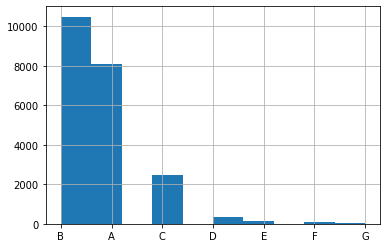

In [ ]:
Fires_KNN['FIRE_SIZE_CLASS'].hist()

- 1st Division (Fire Size Class A)

  - ??? outperformed!

In [ ]:
# 1st Division (Fire Size Class A)
Fires_t3_div1 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'A']
XT3d1_train = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d1_test = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d1_train = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d1_test = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d1 = dict()       
model_T3d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d1 = model().fit(XT3d1_train,XT3d1_test)
  y_T3d1_pred = regressor_T3d1.predict(yT3d1_train)
  model_T3d1_mse = mean_squared_error(y_T3d1_pred,yT3d1_test)
  model_T3d1_mae = mean_absolute_error(y_T3d1_pred,yT3d1_test)
  model_scores_T3d1[model] = (regressor_T3d1,yT3d1_test,y_T3d1_pred)
  model_T3d1_df = model_T3d1_df.append({'Model':model,'MSE':model_T3d1_mse,'MAE':model_T3d1_mae}, ignore_index=True)
  model_T3d1_df = model_T3d1_df.sort_values(by='MSE', ascending= True)
model_T3d1_df.head()

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,0.003789,0.045778
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.003810,0.045280
2,<class 'sklearn.neighbors._regression.KNeighbo...,0.004566,0.051248
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.004650,0.052216
4,<class 'sklearn.linear_model._base.LinearRegre...,0.004752,0.051645


In [ ]:
# Ensemble method
model_ens_t3d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d1 = VotingRegressor(i).fit(XT3d1_train,XT3d1_test)
  # Predict with our ensemble model
  ensemble_t3d1_pred = ensemble_t3d1.predict(yT3d1_train)
  model_ens_t3d1_mse = mean_squared_error(ensemble_t3d1_pred,yT3d1_test)
  model_ens_t3d1_mae = mean_absolute_error(ensemble_t3d1_pred,yT3d1_test)
  model_scores_ens_t3d1 = (ensemble_t3d1,yT3d1_test,ensemble_t3d1_pred)
  model_ens_t3d1_df = model_ens_t3d1_df.append({'Model':i,'MSE':model_ens_t3d1_mse,'MAE':model_ens_t3d1_mae}, ignore_index=True)
  model_ens_t3d1_df = model_ens_t3d1_df.sort_values(by='MSE', ascending= True)
model_ens_t3d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003677,0.044904
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003806,0.046417
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.003881,0.046482
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003913,0.047324
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.003923,0.046351


In [ ]:
model_ens_t3d1_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 2nd Division (Fire Size Class B)

  - ??? outperformed!

In [ ]:
# 2nd Division (Fire Size Class B)
Fires_t3_div2 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'B']
XT3d2_train = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d2_test = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d2_train = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d2_test = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d2 = dict()       
model_T3d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d2 = model().fit(XT3d2_train,XT3d2_test)
  y_T3d2_pred = regressor_T3d2.predict(yT3d2_train)
  model_T3d2_mse = mean_squared_error(y_T3d2_pred,yT3d2_test)
  model_T3d2_mae = mean_absolute_error(y_T3d2_pred,yT3d2_test)
  model_scores_T3d2[model] = (regressor_T3d2,yT3d2_test,y_T3d2_pred)
  model_T3d2_df = model_T3d2_df.append({'Model':model,'MSE':model_T3d2_mse,'MAE':model_T3d2_mae}, ignore_index=True)
  model_T3d2_df = model_T3d2_df.sort_values(by='MSE', ascending= True)
model_T3d2_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,3.947844,1.536869
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,3.988057,1.558925
2,<class 'sklearn.ensemble._forest.RandomForestR...,4.230195,1.603777
3,<class 'sklearn.neighbors._regression.KNeighbo...,4.479950,1.577158
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,4.500489,1.832007
5,<class 'sklearn.svm._classes.SVR'>,4.650026,1.351945


In [ ]:
# Ensemble method
model_ens_t3d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d2 = VotingRegressor(i).fit(XT3d2_train,XT3d2_test)
  # Predict with our ensemble model
  ensemble_t3d2_pred = ensemble_t3d2.predict(yT3d2_train)
  model_ens_t3d2_mse = mean_squared_error(ensemble_t3d2_pred,yT3d2_test)
  model_ens_t3d2_mae = mean_absolute_error(ensemble_t3d2_pred,yT3d2_test)
  model_scores_ens_t3d2 = (ensemble_t3d2,yT3d2_test,ensemble_t3d2_pred)
  model_ens_t3d2_df = model_ens_t3d2_df.append({'Model':i,'MSE':model_ens_t3d2_mse,'MAE':model_ens_t3d2_mae}, ignore_index=True)
  model_ens_t3d2_df = model_ens_t3d2_df.sort_values(by='MSE', ascending= True)
model_ens_t3d2_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",3.893843,1.525431
49,"[(reg1, LinearRegression()), (reg2, RandomFore...",3.898140,1.538077
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",3.903947,1.527386
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",3.905269,1.550901
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",3.911229,1.537242


In [ ]:
model_ens_t3d2_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg3', GradientBoostingRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

- 3rd Division (Fire Size Class C)

  - ??? outperformed!

In [ ]:
# 3rd Division (Fire Size Class C)
Fires_t3_div3 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'C']
XT3d3_train = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d3_test = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d3_train = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d3_test = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d3 = dict()       
model_T3d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d3 = model().fit(XT3d3_train,XT3d3_test)
  y_T3d3_pred = regressor_T3d3.predict(yT3d3_train)
  model_T3d3_mse = mean_squared_error(y_T3d3_pred,yT3d3_test)
  model_T3d3_mae = mean_absolute_error(y_T3d3_pred,yT3d3_test)
  model_scores_T3d3[model] = (regressor_T3d3,yT3d3_test,y_T3d3_pred)
  model_T3d3_df = model_T3d3_df.append({'Model':model,'MSE':model_T3d3_mse,'MAE':model_T3d3_mae}, ignore_index=True)
  model_T3d3_df = model_T3d3_df.sort_values(by='MSE', ascending= True)
model_T3d3_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,439.058107,16.863941
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,492.385678,18.366269
5,<class 'sklearn.svm._classes.SVR'>,537.953679,15.909320
2,<class 'sklearn.ensemble._forest.RandomForestR...,541.329178,19.620139
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,558.966005,20.680309
4,<class 'sklearn.neighbors._regression.KNeighbo...,574.061546,20.004258


In [ ]:
# Ensemble method
model_ens_t3d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d3 = VotingRegressor(i).fit(XT3d3_train,XT3d3_test)
  # Predict with our ensemble model
  ensemble_t3d3_pred = ensemble_t3d3.predict(yT3d3_train)
  model_ens_t3d3_mse = mean_squared_error(ensemble_t3d3_pred,yT3d3_test)
  model_ens_t3d3_mae = mean_absolute_error(ensemble_t3d3_pred,yT3d3_test)
  model_scores_ens_t3d3 = (ensemble_t3d3,yT3d3_test,ensemble_t3d3_pred)
  model_ens_t3d3_df = model_ens_t3d3_df.append({'Model':i,'MSE':model_ens_t3d3_mse,'MAE':model_ens_t3d3_mae}, ignore_index=True)
  model_ens_t3d3_df = model_ens_t3d3_df.sort_values(by='MSE', ascending= True)
model_ens_t3d3_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",444.742781,16.993534
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",456.219096,17.412821
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",459.005898,16.647805
3,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",461.000781,17.402170
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",461.106839,17.344023


In [ ]:
model_ens_t3d3_df['Model'][0]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor()), ('reg6', SVR())]

- 4th Division (Fire Size Class D)

  - ??? outperformed!

In [ ]:
# 4th Division (Fire Size Class D)
Fires_t3_div4 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'D']
XT3d4_train = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d4_test = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d4_train = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d4_test = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d4 = dict()       
model_T3d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d4 = model().fit(XT3d4_train,XT3d4_test)
  y_T3d4_pred = regressor_T3d4.predict(yT3d4_train)
  model_T3d4_mse = mean_squared_error(y_T3d4_pred,yT3d4_test)
  model_T3d4_mae = mean_absolute_error(y_T3d4_pred,yT3d4_test)
  model_scores_T3d4[model] = (regressor_T3d4,yT3d4_test,y_T3d4_pred)
  model_T3d4_df = model_T3d4_df.append({'Model':model,'MSE':model_T3d4_mse,'MAE':model_T3d4_mae}, ignore_index=True)
  model_T3d4_df = model_T3d4_df.sort_values(by='MSE', ascending= True)
model_T3d4_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,2663.683840,47.619999
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,2835.919011,50.675715
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,3065.718560,49.483004
2,<class 'sklearn.linear_model._base.LinearRegre...,3342.461697,52.465355
3,<class 'sklearn.ensemble._forest.RandomForestR...,3629.759558,55.399300
4,<class 'sklearn.neighbors._regression.KNeighbo...,4204.756899,58.360222


In [ ]:
# Ensemble method
model_ens_t3d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d4 = VotingRegressor(i).fit(XT3d4_train,XT3d4_test)
  # Predict with our ensemble model
  ensemble_t3d4_pred = ensemble_t3d4.predict(yT3d4_train)
  model_ens_t3d4_mse = mean_squared_error(ensemble_t3d4_pred,yT3d4_test)
  model_ens_t3d4_mae = mean_absolute_error(ensemble_t3d4_pred,yT3d4_test)
  model_scores_ens_t3d4 = (ensemble_t3d4,yT3d4_test,ensemble_t3d4_pred)
  model_ens_t3d4_df = model_ens_t3d4_df.append({'Model':i,'MSE':model_ens_t3d4_mse,'MAE':model_ens_t3d4_mae}, ignore_index=True)
  model_ens_t3d4_df = model_ens_t3d4_df.sort_values(by='MSE', ascending= True)
model_ens_t3d4_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",2439.863744,46.045886
1,"[(reg3, GradientBoostingRegressor()), (reg6, S...",2710.282864,49.287246
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",2775.437928,49.516198
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",2833.093998,50.086581
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",2848.979783,50.463673


In [ ]:
model_ens_t3d4_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg6', SVR())]

- 5th Division (Fire Size Class E)

  - ??? outperformed!

In [ ]:
# 5th Division (Fire Size Class E)
Fires_t3_div5 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'E']
XT3d5_train = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d5_test = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d5_train = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d5_test = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d5 = dict()       
model_T3d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d5 = model().fit(XT3d5_train,XT3d5_test)
  y_T3d5_pred = regressor_T3d5.predict(yT3d5_train)
  model_T3d5_mse = mean_squared_error(y_T3d5_pred,yT3d5_test)
  model_T3d5_mae = mean_absolute_error(y_T3d5_pred,yT3d5_test)
  model_scores_T3d5[model] = (regressor_T3d5,yT3d5_test,y_T3d5_pred)
  model_T3d5_df = model_T3d5_df.append({'Model':model,'MSE':model_T3d5_mse,'MAE':model_T3d5_mae}, ignore_index=True)
  model_T3d5_df = model_T3d5_df.sort_values(by='MSE', ascending= True)
model_T3d5_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,18501.519625,132.861592
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,29729.331963,146.534505
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,30832.047756,157.338013
2,<class 'sklearn.linear_model._base.LinearRegre...,34646.767934,167.205032
3,<class 'sklearn.ensemble._forest.RandomForestR...,38589.554129,168.980571
4,<class 'sklearn.neighbors._regression.KNeighbo...,40385.772686,175.394286


In [ ]:
# Ensemble method
model_ens_t3d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d5 = VotingRegressor(i).fit(XT3d5_train,XT3d5_test)
  # Predict with our ensemble model
  ensemble_t3d5_pred = ensemble_t3d5.predict(yT3d5_train)
  model_ens_t3d5_mse = mean_squared_error(ensemble_t3d5_pred,yT3d5_test)
  model_ens_t3d5_mae = mean_absolute_error(ensemble_t3d5_pred,yT3d5_test)
  model_scores_ens_t3d5 = (ensemble_t3d5,yT3d5_test,ensemble_t3d5_pred)
  model_ens_t3d5_df = model_ens_t3d5_df.append({'Model':i,'MSE':model_ens_t3d5_mse,'MAE':model_ens_t3d5_mae}, ignore_index=True)
  model_ens_t3d5_df = model_ens_t3d5_df.sort_values(by='MSE', ascending= True)
model_ens_t3d5_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg6, S...",22759.033015,137.638690
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",23314.505933,138.415508
2,"[(reg3, GradientBoostingRegressor()), (reg5, K...",24490.277544,147.662223
3,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",24821.460175,145.102868
4,"[(reg1, LinearRegression()), (reg6, SVR())]",24894.481470,150.033312


In [ ]:
model_ens_t3d5_df['Model'][0]

[('reg3', GradientBoostingRegressor()), ('reg6', SVR())]

- 6th Division (Fire Size Class F)

  - ??? outperformed!

In [ ]:
# 6th Division (Fire Size Class F)
Fires_t3_div6 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'F']
XT3d6_train = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d6_test = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d6_train = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d6_test = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d6 = dict()       
model_T3d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d6 = model().fit(XT3d6_train,XT3d6_test)
  y_T3d6_pred = regressor_T3d6.predict(yT3d6_train)
  model_T3d6_mse = mean_squared_error(y_T3d6_pred,yT3d6_test)
  model_T3d6_mae = mean_absolute_error(y_T3d6_pred,yT3d6_test)
  model_scores_T3d6[model] = (regressor_T3d6,yT3d6_test,y_T3d6_pred)
  model_T3d6_df = model_T3d6_df.append({'Model':model,'MSE':model_T3d6_mse,'MAE':model_T3d6_mae}, ignore_index=True)
  model_T3d6_df = model_T3d6_df.sort_values(by='MSE', ascending= True)
model_T3d6_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,93214.999054,298.817280
1,<class 'sklearn.ensemble._forest.RandomForestR...,277887.625588,482.652000
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,310809.374396,546.213180
3,<class 'sklearn.neighbors._regression.KNeighbo...,423097.136800,643.980000
5,<class 'sklearn.svm._classes.SVR'>,480140.853744,661.926092
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,527980.323414,718.590217


In [ ]:
# Ensemble method
model_ens_t3d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d6 = VotingRegressor(i).fit(XT3d6_train,XT3d6_test)
  # Predict with our ensemble model
  ensemble_t3d6_pred = ensemble_t3d6.predict(yT3d6_train)
  model_ens_t3d6_mse = mean_squared_error(ensemble_t3d6_pred,yT3d6_test)
  model_ens_t3d6_mae = mean_absolute_error(ensemble_t3d6_pred,yT3d6_test)
  model_scores_ens_t3d6 = (ensemble_t3d6,yT3d6_test,ensemble_t3d6_pred)
  model_ens_t3d6_df = model_ens_t3d6_df.append({'Model':i,'MSE':model_ens_t3d6_mse,'MAE':model_ens_t3d6_mae}, ignore_index=True)
  model_ens_t3d6_df = model_ens_t3d6_df.sort_values(by='MSE', ascending= True)
model_ens_t3d6_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",177140.946011,420.046653
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",186110.972845,422.515230
2,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",202764.913034,447.198045
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",207556.133316,455.581335
4,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",211072.285656,457.467486


In [ ]:
model_ens_t3d6_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor())]

- 7th Division (Fire Size Class G)

  - ??? outperformed!

In [ ]:
# 7th Division (Fire Size Class G)
Fires_t3_div7 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'G']
XT3d7_train = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d7_test = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d7_train = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d7_test = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d7 = dict()       
model_T3d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d7 = model().fit(XT3d7_train,XT3d7_test)
  y_T3d7_pred = regressor_T3d7.predict(yT3d7_train)
  model_T3d7_mse = mean_squared_error(y_T3d7_pred,yT3d7_test)
  model_T3d7_mae = mean_absolute_error(y_T3d7_pred,yT3d7_test)
  model_scores_T3d7[model] = (regressor_T3d7,yT3d7_test,y_T3d7_pred)
  model_T3d7_df = model_T3d7_df.append({'Model':model,'MSE':model_T3d7_mse,'MAE':model_T3d7_mae}, ignore_index=True)
  model_T3d7_df = model_T3d7_df.sort_values(by='MSE', ascending= True)
model_T3d7_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,7.872188e+07,8872.476018
0,<class 'sklearn.linear_model._base.LinearRegre...,9.396689e+07,7632.628882
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.306050e+08,10009.395965
2,<class 'sklearn.neighbors._regression.KNeighbo...,1.690104e+08,12440.180000
3,<class 'sklearn.ensemble._forest.RandomForestR...,6.207951e+08,23836.456500
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,7.500629e+08,26910.908333


In [ ]:
# Ensemble method
model_ens_t3d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d7 = VotingRegressor(i).fit(XT3d7_train,XT3d7_test)
  # Predict with our ensemble model
  ensemble_t3d7_pred = ensemble_t3d7.predict(yT3d7_train)
  model_ens_t3d7_mse = mean_squared_error(ensemble_t3d7_pred,yT3d7_test)
  model_ens_t3d7_mae = mean_absolute_error(ensemble_t3d7_pred,yT3d7_test)
  model_scores_ens_t3d7 = (ensemble_t3d7,yT3d7_test,ensemble_t3d7_pred)
  model_ens_t3d7_df = model_ens_t3d7_df.append({'Model':i,'MSE':model_ens_t3d7_mse,'MAE':model_ens_t3d7_mae}, ignore_index=True)
  model_ens_t3d7_df = model_ens_t3d7_df.sort_values(by='MSE', ascending= True)
model_ens_t3d7_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",7.712893e+07,8252.552450
1,"[(reg3, GradientBoostingRegressor()), (reg6, S...",9.164766e+07,9190.439346
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",9.294808e+07,8890.581910
3,"[(reg1, LinearRegression()), (reg5, KNeighbors...",9.364614e+07,9648.428300
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",1.017593e+08,9645.401364


In [ ]:
model_ens_t3d7_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

- 8th Division (Fire Size Class D,E,F,G)

  - ??? outperformed!

In [ ]:
# 8th Division (Fire Size Class D,E,F,G)
Fires_t3_div8 = Fires_KNN[(Fires_KNN['FIRE_SIZE_CLASS'] == 'D') | (Fires_KNN['FIRE_SIZE_CLASS'] == 'E') | (Fires_KNN['FIRE_SIZE_CLASS'] == 'F') | (Fires_KNN['FIRE_SIZE_CLASS'] == 'G')]
XT3d8_train = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT3d8_test = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d8_train = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT3d8_test = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T3d8 = dict()       
model_T3d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d8 = model().fit(XT3d8_train,XT3d8_test)
  y_T3d8_pred = regressor_T3d8.predict(yT3d8_train)
  model_T3d8_mse = mean_squared_error(y_T3d8_pred,yT3d8_test)
  model_T3d8_mae = mean_absolute_error(y_T3d8_pred,yT3d8_test)
  model_scores_T3d8[model] = (regressor_T3d8,yT3d8_test,y_T3d8_pred)
  model_T3d8_df = model_T3d8_df.append({'Model':model,'MSE':model_T3d8_mse,'MAE':model_T3d8_mae}, ignore_index=True)
  model_T3d8_df = model_T3d8_df.sort_values(by='MSE', ascending= True)
model_T3d8_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,3.381740e+06,861.319292
0,<class 'sklearn.linear_model._base.LinearRegre...,1.029710e+07,2088.807537
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.225195e+07,1839.779184
2,<class 'sklearn.neighbors._regression.KNeighbo...,1.273156e+07,2127.444300
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.425161e+07,3064.162357
4,<class 'sklearn.ensemble._forest.RandomForestR...,1.627593e+08,4331.867385


In [ ]:
# Ensemble method
model_ens_t3d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d8 = VotingRegressor(i).fit(XT3d8_train,XT3d8_test)
  # Predict with our ensemble model
  ensemble_t3d8_pred = ensemble_t3d8.predict(yT3d8_train)
  model_ens_t3d8_mse = mean_squared_error(ensemble_t3d8_pred,yT3d8_test)
  model_ens_t3d8_mae = mean_absolute_error(ensemble_t3d8_pred,yT3d8_test)
  model_scores_ens_t3d8 = (ensemble_t3d8,yT3d8_test,ensemble_t3d8_pred)
  model_ens_t3d8_df = model_ens_t3d8_df.append({'Model':i,'MSE':model_ens_t3d8_mse,'MAE':model_ens_t3d8_mae}, ignore_index=True)
  model_ens_t3d8_df = model_ens_t3d8_df.sort_values(by='MSE', ascending= True)
model_ens_t3d8_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg5, K...",2.957339e+06,1171.469294
1,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",3.193313e+06,1137.744669
2,"[(reg3, GradientBoostingRegressor()), (reg6, S...",3.602743e+06,1163.244919
3,"[(reg1, LinearRegression()), (reg5, KNeighbors...",3.737236e+06,1438.768139
4,"[(reg1, LinearRegression()), (reg6, SVR())]",3.934674e+06,1348.606914


In [ ]:
model_ens_t3d8_df['Model'][0]

[('reg3', GradientBoostingRegressor()),
 ('reg5', KNeighborsRegressor()),
 ('reg6', SVR())]

# Trail4: SMOTER: Handle imbalance data

In [ ]:
pip install smogn

In [ ]:
import smogn
Smoter_KNN = smogn.smoter(

    data = Fires_KNN.reset_index(), 
    y = "FIRE_SIZE"
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
r_index: 100%|##########| 1486/1486 [00:04<00:00, 302.26it/s]


### Baseline of SMOTER

In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_SMOTER_train = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
X_SMOTER_test = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_SMOTER_train = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y_SMOTER_test = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_SMOTER = dict()    
model_SMOTER_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_SMOTER = model().fit(X_SMOTER_train,X_SMOTER_test)
  y_SMOTER_pred = regressor_SMOTER.predict(y_SMOTER_train)
  model_SMOTER_mse = mean_squared_error(y_SMOTER_pred,y_SMOTER_test)
  model_SMOTER_mae = mean_absolute_error(y_SMOTER_pred,y_SMOTER_test)
  model_scores_SMOTER[model] = (regressor_SMOTER,y_SMOTER_test,y_SMOTER_pred)
  model_SMOTER_df = model_SMOTER_df.append({'Model':model,'MSE':model_SMOTER_mse,'MAE':model_SMOTER_mae}, ignore_index=True)
  model_SMOTER_df = model_SMOTER_df.sort_values(by='MSE', ascending= True)
model_SMOTER_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,1.782931e+05,57.319053
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,4.176685e+05,172.845429
1,<class 'sklearn.linear_model._base.LinearRegre...,6.262688e+05,261.647880
2,<class 'sklearn.ensemble._forest.RandomForestR...,6.954719e+05,165.994479
3,<class 'sklearn.neighbors._regression.KNeighbo...,9.008822e+05,213.080927
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,9.481926e+06,1107.964258


## Use ensemble method

In [ ]:
model_ens_t4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4 = VotingRegressor(i).fit(X_SMOTER_train,X_SMOTER_test)
  # Predict with our ensemble model
  ensemble_t4_pred = ensemble_t4.predict(y_SMOTER_train)
  model_ens_t4_mse = mean_squared_error(ensemble_t4_pred,y_SMOTER_test)
  model_ens_t4_mae = mean_absolute_error(ensemble_t4_pred,y_SMOTER_test)
  model_scores_ens_t4 = (ensemble_t4,y_SMOTER_test,ensemble_t4_pred)
  model_ens_t4_df = model_ens_t4_df.append({'Model':i,'MSE':model_ens_t4_mse,'MAE':model_ens_t4_mae}, ignore_index=True)
  model_ens_t4_df = model_ens_t4_df.sort_values(by='MSE', ascending= True)
model_ens_t4_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg6, S...",223005.335178,110.237964
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",225135.330386,117.345296
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",232003.813089,138.470520
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",248302.045915,152.040006
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",262893.662421,149.829013


- 1st Division (Fire Size < 1)

  - ??? outperformed!

In [ ]:
# 1st Division (Fire Size < 1)
Fires_t4_div1 = Smoter_KNN[Smoter_KNN['FIRE_SIZE'] <= 1]
XT4d1_train = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d1_test = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d1_train = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d1_test = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d1 = dict()       
model_T4d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d1 = model().fit(XT4d1_train,XT4d1_test)
  y_T4d1_pred = regressor_T4d1.predict(yT4d1_train)
  model_T4d1_mse = mean_squared_error(y_T4d1_pred,yT4d1_test)
  model_T4d1_mae = mean_absolute_error(y_T4d1_pred,yT4d1_test)
  model_scores_T4d1[model] = (regressor_T4d1,yT4d1_test,y_T4d1_pred)
  model_T4d1_df = model_T4d1_df.append({'Model':model,'MSE':model_T4d1_mse,'MAE':model_T4d1_mae}, ignore_index=True)
  model_T4d1_df = model_T4d1_df.sort_values(by='MSE', ascending= True)
model_T4d1_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.099028,0.259937
1,<class 'sklearn.ensemble._forest.RandomForestR...,0.106230,0.257761
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.112540,0.296577
3,<class 'sklearn.linear_model._base.LinearRegre...,0.113596,0.284014
5,<class 'sklearn.svm._classes.SVR'>,0.125334,0.247275
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.126827,0.267321


In [ ]:
# Ensemble method
model_ens_t4d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d1 = VotingRegressor(i).fit(XT4d1_train,XT4d1_test)
  # Predict with our ensemble model
  ensemble_t4d1_pred = ensemble_t4d1.predict(yT4d1_train)
  model_ens_t4d1_mse = mean_squared_error(ensemble_t4d1_pred,yT4d1_test)
  model_ens_t4d1_mae = mean_absolute_error(ensemble_t4d1_pred,yT4d1_test)
  model_scores_ens_t4d1 = (ensemble_t4d1,yT4d1_test,ensemble_t4d1_pred)
  model_ens_t4d1_df = model_ens_t4d1_df.append({'Model':i,'MSE':model_ens_t4d1_mse,'MAE':model_ens_t4d1_mae}, ignore_index=True)
  model_ens_t4d1_df = model_ens_t4d1_df.sort_values(by='MSE', ascending= True)
model_ens_t4d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.097607,0.244496
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.099476,0.252803
2,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",0.100053,0.238878
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.100306,0.257233
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.100512,0.248887


In [ ]:
model_ens_t4d1_df['Model'][0]

[('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg6', SVR())]

- 2nd Division (1<= Fire Size <= 2)

  - ??? outperformed!

In [ ]:
# 2nd Division (1<= Fire Size <= 2)
Fires_t4_div2 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] >= 1) & (Smoter_KNN['FIRE_SIZE'] <= 2)]
XT4d2_train = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d2_test = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d2_train = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d2_test = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d2 = dict()       
model_T4d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d2 = model().fit(XT4d2_train,XT4d2_test)
  y_T4d2_pred = regressor_T4d2.predict(yT4d2_train)
  model_T4d2_mse = mean_squared_error(y_T4d2_pred,yT4d2_test)
  model_T4d2_mae = mean_absolute_error(y_T4d2_pred,yT4d2_test)
  model_scores_T4d2[model] = (regressor_T4d2,yT4d2_test,y_T4d2_pred)
  model_T4d2_df = model_T4d2_df.append({'Model':model,'MSE':model_T4d2_mse,'MAE':model_T4d2_mae}, ignore_index=True)
  model_T4d2_df = model_T4d2_df.sort_values(by='MSE', ascending= True)
model_T4d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.157726,0.370597
1,<class 'sklearn.linear_model._base.LinearRegre...,0.160196,0.373777
5,<class 'sklearn.svm._classes.SVR'>,0.160487,0.271061
2,<class 'sklearn.ensemble._forest.RandomForestR...,0.168812,0.361279
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.171897,0.395246
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.194629,0.382617


In [ ]:
# Ensemble method
model_ens_t4d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d2 = VotingRegressor(i).fit(XT4d2_train,XT4d2_test)
  # Predict with our ensemble model
  ensemble_t4d2_pred = ensemble_t4d2.predict(yT4d2_train)
  model_ens_t4d2_mse = mean_squared_error(ensemble_t4d2_pred,yT4d2_test)
  model_ens_t4d2_mae = mean_absolute_error(ensemble_t4d2_pred,yT4d2_test)
  model_scores_ens_t4d2 = (ensemble_t4d2,yT4d2_test,ensemble_t4d2_pred)
  model_ens_t4d2_df = model_ens_t4d2_df.append({'Model':i,'MSE':model_ens_t4d2_mse,'MAE':model_ens_t4d2_mae}, ignore_index=True)
  model_ens_t4d2_df = model_ens_t4d2_df.sort_values(by='MSE', ascending= True)
model_ens_t4d2_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg6, S...",0.141386,0.319862
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.144227,0.337943
2,"[(reg3, GradientBoostingRegressor()), (reg4, A...",0.144386,0.342369
3,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",0.146026,0.328009
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.146157,0.343201


In [ ]:
model_ens_t4d2_df['Model'][0]

[('reg3', GradientBoostingRegressor()), ('reg6', SVR())]

- 3rd Division (2< Fire Size <= 5)

  - ??? outperformed!

In [ ]:
# 3rd Division (2 < Fire Size <= 5)
Fires_t4_div3 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 2) & (Smoter_KNN['FIRE_SIZE'] <= 5)]
XT4d3_train = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d3_test = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d3_train = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d3_test = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d3 = dict()       
model_T4d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d3 = model().fit(XT4d3_train,XT4d3_test)
  y_T4d3_pred = regressor_T4d3.predict(yT4d3_train)
  model_T4d3_mse = mean_squared_error(y_T4d3_pred,yT4d3_test)
  model_T4d3_mae = mean_absolute_error(y_T4d3_pred,yT4d3_test)
  model_scores_T4d3[model] = (regressor_T4d3,yT4d3_test,y_T4d3_pred)
  model_T4d3_df = model_T4d3_df.append({'Model':model,'MSE':model_T4d3_mse,'MAE':model_T4d3_mae}, ignore_index=True)
  model_T4d3_df = model_T4d3_df.sort_values(by='MSE', ascending= True)
model_T4d3_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.765394,0.715033
1,<class 'sklearn.linear_model._base.LinearRegre...,0.794245,0.724794
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.821678,0.809587
3,<class 'sklearn.neighbors._regression.KNeighbo...,0.840864,0.681283
4,<class 'sklearn.ensemble._forest.RandomForestR...,0.862803,0.736278
5,<class 'sklearn.svm._classes.SVR'>,1.053413,0.721560


In [ ]:
# Ensemble method
model_ens_t4d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d3 = VotingRegressor(i).fit(XT4d3_train,XT4d3_test)
  # Predict with our ensemble model
  ensemble_t4d3_pred = ensemble_t4d3.predict(yT4d3_train)
  model_ens_t4d3_mse = mean_squared_error(ensemble_t4d3_pred,yT4d3_test)
  model_ens_t4d3_mae = mean_absolute_error(ensemble_t4d3_pred,yT4d3_test)
  model_scores_ens_t4d3 = (ensemble_t4d3,yT4d3_test,ensemble_t4d3_pred)
  model_ens_t4d3_df = model_ens_t4d3_df.append({'Model':i,'MSE':model_ens_t4d3_mse,'MAE':model_ens_t4d3_mae}, ignore_index=True)
  model_ens_t4d3_df = model_ens_t4d3_df.sort_values(by='MSE', ascending= True)
model_ens_t4d3_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.729104,0.708623
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.735355,0.713981
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.737891,0.691114
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",0.739088,0.672435
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.746014,0.734904


In [ ]:
model_ens_t4d3_df['Model'][0]

[('reg1', LinearRegression()), ('reg3', GradientBoostingRegressor())]

- 4th Division (5< Fire Size <= 15)

  - ??? outperformed!

In [ ]:
# 4th Division (5 < Fire Size <= 15)
Fires_t4_div4 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 5) & (Smoter_KNN['FIRE_SIZE'] <= 15)]
XT4d4_train = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d4_test = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d4_train = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d4_test = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d4 = dict()       
model_T4d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d4 = model().fit(XT4d4_train,XT4d4_test)
  y_T4d4_pred = regressor_T4d4.predict(yT4d4_train)
  model_T4d4_mse = mean_squared_error(y_T4d4_pred,yT4d4_test)
  model_T4d4_mae = mean_absolute_error(y_T4d4_pred,yT4d4_test)
  model_scores_T4d4[model] = (regressor_T4d4,yT4d4_test,y_T4d4_pred)
  model_T4d4_df = model_T4d4_df.append({'Model':model,'MSE':model_T4d4_mse,'MAE':model_T4d4_mae}, ignore_index=True)
  model_T4d4_df = model_T4d4_df.sort_values(by='MSE', ascending= True)
model_T4d4_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,8.982950,2.464773
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,10.577290,2.718265
2,<class 'sklearn.linear_model._base.LinearRegre...,10.717204,2.790918
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,10.827854,2.779513
4,<class 'sklearn.neighbors._regression.KNeighbo...,13.072393,2.897515
5,<class 'sklearn.svm._classes.SVR'>,13.542932,2.909966


In [ ]:
# Ensemble method
model_ens_t4d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d4 = VotingRegressor(i).fit(XT4d4_train,XT4d4_test)
  # Predict with our ensemble model
  ensemble_t4d4_pred = ensemble_t4d4.predict(yT4d4_train)
  model_ens_t4d4_mse = mean_squared_error(ensemble_t4d4_pred,yT4d4_test)
  model_ens_t4d4_mae = mean_absolute_error(ensemble_t4d4_pred,yT4d4_test)
  model_scores_ens_t4d4 = (ensemble_t4d4,yT4d4_test,ensemble_t4d4_pred)
  model_ens_t4d4_df = model_ens_t4d4_df.append({'Model':i,'MSE':model_ens_t4d4_mse,'MAE':model_ens_t4d4_mae}, ignore_index=True)
  model_ens_t4d4_df = model_ens_t4d4_df.sort_values(by='MSE', ascending= True)
model_ens_t4d4_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",9.369429,2.577254
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",9.489288,2.542485
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",9.549060,2.628956
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",9.617338,2.598204
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",9.792831,2.654670


In [ ]:
model_ens_t4d4_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg4', AdaBoostRegressor())]

- 5th Division (15< Fire Size <= 40)

  - ??? outperformed!

In [ ]:
# 5th Division (15 < Fire Size <= 40)
Fires_t4_div5 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 15) & (Smoter_KNN['FIRE_SIZE'] <= 40)]
XT4d5_train = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d5_test = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d5_train = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d5_test = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d5 = dict()       
model_T4d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d5 = model().fit(XT4d5_train,XT4d5_test)
  y_T4d5_pred = regressor_T4d5.predict(yT4d5_train)
  model_T4d5_mse = mean_squared_error(y_T4d5_pred,yT4d5_test)
  model_T4d5_mae = mean_absolute_error(y_T4d5_pred,yT4d5_test)
  model_scores_T4d5[model] = (regressor_T4d5,yT4d5_test,y_T4d5_pred)
  model_T4d5_df = model_T4d5_df.append({'Model':model,'MSE':model_T4d5_mse,'MAE':model_T4d5_mae}, ignore_index=True)
  model_T4d5_df = model_T4d5_df.sort_values(by='MSE', ascending= True)
model_T4d5_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,47.488640,5.781399
1,<class 'sklearn.linear_model._base.LinearRegre...,50.788907,5.905719
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,53.282639,6.037644
3,<class 'sklearn.neighbors._regression.KNeighbo...,53.679250,5.951781
4,<class 'sklearn.ensemble._forest.RandomForestR...,55.833784,5.882349
5,<class 'sklearn.svm._classes.SVR'>,58.295818,6.103102


In [ ]:
# Ensemble method
model_ens_t4d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d5 = VotingRegressor(i).fit(XT4d5_train,XT4d5_test)
  # Predict with our ensemble model
  ensemble_t4d5_pred = ensemble_t4d5.predict(yT4d5_train)
  model_ens_t4d5_mse = mean_squared_error(ensemble_t4d5_pred,yT4d5_test)
  model_ens_t4d5_mae = mean_absolute_error(ensemble_t4d5_pred,yT4d5_test)
  model_scores_ens_t4d5 = (ensemble_t4d5,yT4d5_test,ensemble_t4d5_pred)
  model_ens_t4d5_df = model_ens_t4d5_df.append({'Model':i,'MSE':model_ens_t4d5_mse,'MAE':model_ens_t4d5_mae}, ignore_index=True)
  model_ens_t4d5_df = model_ens_t4d5_df.sort_values(by='MSE', ascending= True)
model_ens_t4d5_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",48.184274,5.741568
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",48.373004,5.732312
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",48.748270,5.774749
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",48.881941,5.792308
4,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",49.340322,5.806320


In [ ]:
model_ens_t4d5_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg5', KNeighborsRegressor())]

- 6th Division (40< Fire Size <= 150)

  - ??? outperformed!

In [ ]:
# 6th Division (40 < Fire Size <= 150)
Fires_t4_div6 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 40) & (Smoter_KNN['FIRE_SIZE'] <= 150)]
XT4d6_train = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d6_test = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d6_train = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d6_test = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d6 = dict()       
model_T4d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d6 = model().fit(XT4d6_train,XT4d6_test)
  y_T4d6_pred = regressor_T4d6.predict(yT4d6_train)
  model_T4d6_mse = mean_squared_error(y_T4d6_pred,yT4d6_test)
  model_T4d6_mae = mean_absolute_error(y_T4d6_pred,yT4d6_test)
  model_scores_T4d6[model] = (regressor_T4d6,yT4d6_test,y_T4d6_pred)
  model_T4d6_df = model_T4d6_df.append({'Model':model,'MSE':model_T4d6_mse,'MAE':model_T4d6_mae}, ignore_index=True)
  model_T4d6_df = model_T4d6_df.sort_values(by='MSE', ascending= True)
model_T4d6_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,682.174978,20.582270
0,<class 'sklearn.linear_model._base.LinearRegre...,1075.704698,28.326458
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,1182.279412,31.254115
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,1259.939927,30.760915
3,<class 'sklearn.ensemble._forest.RandomForestR...,1421.598861,32.251222
4,<class 'sklearn.neighbors._regression.KNeighbo...,1469.484803,30.805686


In [ ]:
# Ensemble method
model_ens_t4d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d6 = VotingRegressor(i).fit(XT4d6_train,XT4d6_test)
  # Predict with our ensemble model
  ensemble_t4d6_pred = ensemble_t4d6.predict(yT4d6_train)
  model_ens_t4d6_mse = mean_squared_error(ensemble_t4d6_pred,yT4d6_test)
  model_ens_t4d6_mae = mean_absolute_error(ensemble_t4d6_pred,yT4d6_test)
  model_scores_ens_t4d6 = (ensemble_t4d6,yT4d6_test,ensemble_t4d6_pred)
  model_ens_t4d6_df = model_ens_t4d6_df.append({'Model':i,'MSE':model_ens_t4d6_mse,'MAE':model_ens_t4d6_mae}, ignore_index=True)
  model_ens_t4d6_df = model_ens_t4d6_df.sort_values(by='MSE', ascending= True)
model_ens_t4d6_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",787.443466,23.752812
1,"[(reg3, GradientBoostingRegressor()), (reg6, S...",799.873203,24.626670
2,"[(reg1, LinearRegression()), (reg6, SVR())]",809.170616,23.378118
3,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",827.726104,23.708512
4,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",853.127610,24.621123


In [ ]:
model_ens_t4d6_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg6', SVR())]

- 7th Division (150< Fire Size <= 1000)

  - ??? outperformed!

In [ ]:
# 7th Division (150 < Fire Size <= 600)
Fires_t4_div7 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 150) & (Smoter_KNN['FIRE_SIZE'] <= 600)]
XT4d7_train = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d7_test = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d7_train = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d7_test = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d7 = dict()       
model_T4d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d7 = model().fit(XT4d7_train,XT4d7_test)
  y_T4d7_pred = regressor_T4d7.predict(yT4d7_train)
  model_T4d7_mse = mean_squared_error(y_T4d7_pred,yT4d7_test)
  model_T4d7_mae = mean_absolute_error(y_T4d7_pred,yT4d7_test)
  model_scores_T4d7[model] = (regressor_T4d7,yT4d7_test,y_T4d7_pred)
  model_T4d7_df = model_T4d7_df.append({'Model':model,'MSE':model_T4d7_mse,'MAE':model_T4d7_mae}, ignore_index=True)
  model_T4d7_df = model_T4d7_df.sort_values(by='MSE', ascending= True)
model_T4d7_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,8705.918894,68.787430
1,<class 'sklearn.linear_model._base.LinearRegre...,10260.627740,85.216405
5,<class 'sklearn.svm._classes.SVR'>,10415.129159,82.769394
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,12219.877350,96.173962
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,13237.646030,88.906838
4,<class 'sklearn.neighbors._regression.KNeighbo...,15222.656040,102.840345


In [ ]:
# Ensemble method
model_ens_t4d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d7 = VotingRegressor(i).fit(XT4d7_train,XT4d7_test)
  # Predict with our ensemble model
  ensemble_t4d7_pred = ensemble_t4d7.predict(yT4d7_train)
  model_ens_t4d7_mse = mean_squared_error(ensemble_t4d7_pred,yT4d7_test)
  model_ens_t4d7_mae = mean_absolute_error(ensemble_t4d7_pred,yT4d7_test)
  model_scores_ens_t4d7 = (ensemble_t4d7,yT4d7_test,ensemble_t4d7_pred)
  model_ens_t4d7_df = model_ens_t4d7_df.append({'Model':i,'MSE':model_ens_t4d7_mse,'MAE':model_ens_t4d7_mae}, ignore_index=True)
  model_ens_t4d7_df = model_ens_t4d7_df.sort_values(by='MSE', ascending= True)
model_ens_t4d7_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",8498.223581,73.876315
1,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",8697.665449,72.143985
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",8961.032455,76.926089
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",9002.820258,76.585877
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",9418.401412,80.471267


In [ ]:
model_ens_t4d7_df['Model'][0]

[('reg2', RandomForestRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg6', SVR())]

- 8th Division (600< Fire Size <= 1000)

  - ??? outperformed!

In [ ]:
# 8th Division (600 < Fire Size <= 1000)
Fires_t4_div8 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 600) & (Smoter_KNN['FIRE_SIZE'] <= 1000)]
XT4d8_train = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d8_test = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d8_train = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d8_test = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d8 = dict()       
model_T4d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d8 = model().fit(XT4d8_train,XT4d8_test)
  y_T4d8_pred = regressor_T4d8.predict(yT4d8_train)
  model_T4d8_mse = mean_squared_error(y_T4d8_pred,yT4d8_test)
  model_T4d8_mae = mean_absolute_error(y_T4d8_pred,yT4d8_test)
  model_scores_T4d8[model] = (regressor_T4d8,yT4d8_test,y_T4d8_pred)
  model_T4d8_df = model_T4d8_df.append({'Model':model,'MSE':model_T4d8_mse,'MAE':model_T4d8_mae}, ignore_index=True)
  model_T4d8_df = model_T4d8_df.sort_values(by='MSE', ascending= True)
model_T4d8_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,3258.953360,57.087243
1,<class 'sklearn.ensemble._forest.RandomForestR...,10704.002133,103.460148
5,<class 'sklearn.svm._classes.SVR'>,12723.761384,112.799652
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,14690.388903,121.203915
3,<class 'sklearn.linear_model._base.LinearRegre...,15753.408356,125.512582
4,<class 'sklearn.neighbors._regression.KNeighbo...,31275.881534,176.849884


In [ ]:
# Ensemble method
model_ens_t4d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d8 = VotingRegressor(i).fit(XT4d8_train,XT4d8_test)
  # Predict with our ensemble model
  ensemble_t4d8_pred = ensemble_t4d8.predict(yT4d8_train)
  model_ens_t4d8_mse = mean_squared_error(ensemble_t4d8_pred,yT4d8_test)
  model_ens_t4d8_mae = mean_absolute_error(ensemble_t4d8_pred,yT4d8_test)
  model_scores_ens_t4d8 = (ensemble_t4d8,yT4d8_test,ensemble_t4d8_pred)
  model_ens_t4d8_df = model_ens_t4d8_df.append({'Model':i,'MSE':model_ens_t4d8_mse,'MAE':model_ens_t4d8_mae}, ignore_index=True)
  model_ens_t4d8_df = model_ens_t4d8_df.sort_values(by='MSE', ascending= True)
model_ens_t4d8_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",6390.795811,79.942453
1,"[(reg3, GradientBoostingRegressor()), (reg4, A...",6415.321433,80.095702
2,"[(reg3, GradientBoostingRegressor()), (reg6, S...",7215.389268,84.943447
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",7851.717874,88.609920
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",8479.055947,92.081789


In [ ]:
model_ens_t4d8_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 9th Division (1000< Fire Size <= 10000)

  - ??? outperformed!

In [ ]:
# 9th Division (1000 < Fire Size <= 10000)
Fires_t4_div9 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 1000) & (Smoter_KNN['FIRE_SIZE'] <= 10000)]
XT4d9_train = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d9_test = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d9_train = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d9_test = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d9 = dict()       
model_T4d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d9 = model().fit(XT4d9_train,XT4d9_test)
  y_T4d9_pred = regressor_T4d9.predict(yT4d9_train)
  model_T4d9_mse = mean_squared_error(y_T4d9_pred,yT4d9_test)
  model_T4d9_mae = mean_absolute_error(y_T4d9_pred,yT4d9_test)
  model_scores_T4d9[model] = (regressor_T4d9,yT4d9_test,y_T4d9_pred)
  model_T4d9_df = model_T4d9_df.append({'Model':model,'MSE':model_T4d9_mse,'MAE':model_T4d9_mae}, ignore_index=True)
  model_T4d9_df = model_T4d9_df.sort_values(by='MSE', ascending= True)
model_T4d9_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,1.436007e+06,959.774454
1,<class 'sklearn.neighbors._regression.KNeighbo...,1.832358e+06,1123.793549
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.955725e+06,1055.096952
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,2.117350e+06,1352.894817
4,<class 'sklearn.linear_model._base.LinearRegre...,4.178075e+06,1757.220069
5,<class 'sklearn.svm._classes.SVR'>,5.855717e+06,1943.923599


In [ ]:
# Ensemble method
model_ens_t4d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d9 = VotingRegressor(i).fit(XT4d9_train,XT4d9_test)
  # Predict with our ensemble model
  ensemble_t4d9_pred = ensemble_t4d9.predict(yT4d9_train)
  model_ens_t4d9_mse = mean_squared_error(ensemble_t4d9_pred,yT4d9_test)
  model_ens_t4d9_mae = mean_absolute_error(ensemble_t4d9_pred,yT4d9_test)
  model_scores_ens_t4d9 = (ensemble_t4d9,yT4d9_test,ensemble_t4d9_pred)
  model_ens_t4d9_df = model_ens_t4d9_df.append({'Model':i,'MSE':model_ens_t4d9_mse,'MAE':model_ens_t4d9_mae}, ignore_index=True)
  model_ens_t4d9_df = model_ens_t4d9_df.sort_values(by='MSE', ascending= True)
model_ens_t4d9_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",1.227189e+06,745.807691
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",1.281277e+06,975.644587
2,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",1.369994e+06,1050.320564
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",1.405086e+06,896.502153
4,"[(reg3, GradientBoostingRegressor()), (reg4, A...",1.417084e+06,922.738663


In [ ]:
model_ens_t4d9_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg5', KNeighborsRegressor())]

- 10th Division (Fire Size > 10000)

  - KNeighborsRegressor outperformed!

In [ ]:
# 10th Division (Fire Size > 10000)
Fires_t4_div10 = Smoter_KNN[Smoter_KNN['FIRE_SIZE'] > 10000]
XT4d10_train = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT4d10_test = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d10_train = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT4d10_test = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d10 = dict()       
model_T4d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d10 = model().fit(XT4d10_train,XT4d10_test)
  y_T4d10_pred = regressor_T4d10.predict(yT4d10_train)
  model_T4d10_mse = mean_squared_error(y_T4d10_pred,yT4d10_test)
  model_T4d10_mae = mean_absolute_error(y_T4d10_pred,yT4d10_test)
  model_scores_T4d10[model] = (regressor_T4d10,yT4d10_test,y_T4d10_pred)
  model_T4d10_df = model_T4d10_df.append({'Model':model,'MSE':model_T4d10_mse,'MAE':model_T4d10_mae}, ignore_index=True)
  model_T4d10_df = model_T4d10_df.sort_values(by='MSE', ascending= True)
model_T4d10_df

ValueError: ignored

In [ ]:
# Ensemble method
model_ens_t4d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d10 = VotingRegressor(i).fit(XT4d10_train,XT4d10_test)
  # Predict with our ensemble model
  ensemble_t4d10_pred = ensemble_t4d10.predict(yT4d10_train)
  model_ens_t4d10_mse = mean_squared_error(ensemble_t4d10_pred,yT4d10_test)
  model_ens_t4d10_mae = mean_absolute_error(ensemble_t4d10_pred,yT4d10_test)
  model_scores_ens_t4d10 = (ensemble_t4d10,yT4d10_test,ensemble_t4d10_pred)
  model_ens_t4d10_df = model_ens_t4d10_df.append({'Model':i,'MSE':model_ens_t4d10_mse,'MAE':model_ens_t4d10_mae}, ignore_index=True)
  model_ens_t4d10_df = model_ens_t4d10_df.sort_values(by='MSE', ascending= True)
model_ens_t4d10_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",1.316211e+05,362.796170
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",3.838873e+05,619.586422
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",1.731002e+06,1315.675517
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",1.930780e+06,1389.525004
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",1.969125e+06,1403.255265


In [ ]:
model_ens_t4d10_df['Model'][0]

# Trial 5: SMOTER (Divide dataset by FIRE_SIZE_CLASS)

- 1st Division (Fire Size Class A)

  - ??? outperformed!

In [ ]:
# 1st Division (Fire Size Class A)
Fires_t5_div1 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'A']
XT5d1_train = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT5d1_test = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d1_train = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT5d1_test = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T5d1 = dict()       
model_T5d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d1 = model().fit(XT5d1_train,XT5d1_test)
  y_T5d1_pred = regressor_T5d1.predict(yT5d1_train)
  model_T5d1_mse = mean_squared_error(y_T5d1_pred,yT5d1_test)
  model_T5d1_mae = mean_absolute_error(y_T5d1_pred,yT5d1_test)
  model_scores_T5d1[model] = (regressor_T5d1,yT5d1_test,y_T5d1_pred)
  model_T5d1_df = model_T5d1_df.append({'Model':model,'MSE':model_T5d1_mse,'MAE':model_T5d1_mae}, ignore_index=True)
  model_T5d1_df = model_T5d1_df.sort_values(by='MSE', ascending= True)
model_T5d1_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.003467,0.042048
1,<class 'sklearn.ensemble._forest.RandomForestR...,0.003672,0.043862
2,<class 'sklearn.linear_model._base.LinearRegre...,0.004305,0.047654
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.004708,0.055151
5,<class 'sklearn.svm._classes.SVR'>,0.004915,0.054608
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.005293,0.055314


In [ ]:
# Ensemble method
model_ens_t5d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d1 = VotingRegressor(i).fit(XT5d1_train,XT5d1_test)
  # Predict with our ensemble model
  ensemble_t5d1_pred = ensemble_t5d1.predict(yT5d1_train)
  model_ens_t5d1_mse = mean_squared_error(ensemble_t5d1_pred,yT5d1_test)
  model_ens_t5d1_mae = mean_absolute_error(ensemble_t5d1_pred,yT5d1_test)
  model_scores_ens_t5d1 = (ensemble_t5d1,yT5d1_test,ensemble_t5d1_pred)
  model_ens_t5d1_df = model_ens_t5d1_df.append({'Model':i,'MSE':model_ens_t5d1_mse,'MAE':model_ens_t5d1_mae}, ignore_index=True)
  model_ens_t5d1_df = model_ens_t5d1_df.sort_values(by='MSE', ascending= True)
model_ens_t5d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003554,0.043057
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.003615,0.042961
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003685,0.044699
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003742,0.044983
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.003745,0.044663


In [ ]:
model_ens_t5d1_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 2nd Division (Fire Size Class B)

  - ??? outperformed!

In [ ]:
# 2nd Division (Fire Size Class B)
Fires_t5_div2 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'B']
XT5d2_train = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT5d2_test = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d2_train = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT5d2_test = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T5d2 = dict()       
model_T5d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d2 = model().fit(XT5d2_train,XT5d2_test)
  y_T5d2_pred = regressor_T5d2.predict(yT5d2_train)
  model_T5d2_mse = mean_squared_error(y_T5d2_pred,yT5d2_test)
  model_T5d2_mae = mean_absolute_error(y_T5d2_pred,yT5d2_test)
  model_scores_T5d2[model] = (regressor_T5d2,yT5d2_test,y_T5d2_pred)
  model_T5d2_df = model_T5d2_df.append({'Model':model,'MSE':model_T5d2_mse,'MAE':model_T5d2_mae}, ignore_index=True)
  model_T5d2_df = model_T5d2_df.sort_values(by='MSE', ascending= True)
model_T5d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,6.678944e+00,2.247937
1,<class 'sklearn.neighbors._regression.KNeighbo...,7.147664e+00,2.178592
5,<class 'sklearn.svm._classes.SVR'>,9.645688e+00,2.656222
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.377744e+01,3.172739
3,<class 'sklearn.linear_model._base.LinearRegre...,1.895084e+04,107.811038
4,<class 'sklearn.ensemble._forest.RandomForestR...,1.390423e+07,293.156539


In [ ]:
# Ensemble method
model_ens_t5d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d2 = VotingRegressor(i).fit(XT5d2_train,XT5d2_test)
  # Predict with our ensemble model
  ensemble_t5d2_pred = ensemble_t5d2.predict(yT5d2_train)
  model_ens_t5d2_mse = mean_squared_error(ensemble_t5d2_pred,yT5d2_test)
  model_ens_t5d2_mae = mean_absolute_error(ensemble_t5d2_pred,yT5d2_test)
  model_scores_ens_t5d2 = (ensemble_t5d2,yT5d2_test,ensemble_t5d2_pred)
  model_ens_t5d2_df = model_ens_t5d2_df.append({'Model':i,'MSE':model_ens_t5d2_mse,'MAE':model_ens_t5d2_mae}, ignore_index=True)
  model_ens_t5d2_df = model_ens_t5d2_df.sort_values(by='MSE', ascending= True)
model_ens_t5d2_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",6.949973,2.236021
1,"[(reg3, GradientBoostingRegressor()), (reg5, K...",7.156775,2.285366
2,"[(reg3, GradientBoostingRegressor()), (reg4, A...",7.173323,2.265496
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",7.314132,2.324554
4,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",7.375414,2.335865


In [ ]:
model_ens_t5d2_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg5', KNeighborsRegressor())]

- 3rd Division (Fire Size Class C)

  - ??? outperformed!

In [ ]:
# 3rd Division (Fire Size Class C)
Fires_t5_div3 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'C']
XT5d3_train = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT5d3_test = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d3_train = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT5d3_test = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T5d3 = dict()       
model_T5d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d3 = model().fit(XT5d3_train,XT5d3_test)
  y_T5d3_pred = regressor_T5d3.predict(yT5d3_train)
  model_T5d3_mse = mean_squared_error(y_T5d3_pred,yT5d3_test)
  model_T5d3_mae = mean_absolute_error(y_T5d3_pred,yT5d3_test)
  model_scores_T5d3[model] = (regressor_T5d3,yT5d3_test,y_T5d3_pred)
  model_T5d3_df = model_T5d3_df.append({'Model':model,'MSE':model_T5d3_mse,'MAE':model_T5d3_mae}, ignore_index=True)
  model_T5d3_df = model_T5d3_df.sort_values(by='MSE', ascending= True)
model_T5d3_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,351.934230,14.255820
1,<class 'sklearn.ensemble._forest.RandomForestR...,355.624171,14.168237
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,383.069116,15.143209
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,397.663757,16.780777
5,<class 'sklearn.svm._classes.SVR'>,407.355669,13.621547
4,<class 'sklearn.neighbors._regression.KNeighbo...,471.876996,16.727744


In [ ]:
# Ensemble method
model_ens_t5d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d3 = VotingRegressor(i).fit(XT5d3_train,XT5d3_test)
  # Predict with our ensemble model
  ensemble_t5d3_pred = ensemble_t5d3.predict(yT5d3_train)
  model_ens_t5d3_mse = mean_squared_error(ensemble_t5d3_pred,yT5d3_test)
  model_ens_t5d3_mae = mean_absolute_error(ensemble_t5d3_pred,yT5d3_test)
  model_scores_ens_t5d3 = (ensemble_t5d3,yT5d3_test,ensemble_t5d3_pred)
  model_ens_t5d3_df = model_ens_t5d3_df.append({'Model':i,'MSE':model_ens_t5d3_mse,'MAE':model_ens_t5d3_mae}, ignore_index=True)
  model_ens_t5d3_df = model_ens_t5d3_df.sort_values(by='MSE', ascending= True)
model_ens_t5d3_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",347.542719,14.173114
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",352.497810,13.710136
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",354.085050,14.519595
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",354.774339,14.974575
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",355.475665,14.419308


In [ ]:
model_ens_t5d3_df['Model'][0]

[('reg1', LinearRegression()), ('reg2', RandomForestRegressor())]

- 4th Division (Fire Size Class D)

  - ??? outperformed!

In [ ]:
# 4th Division (Fire Size Class D)
Fires_t5_div4 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'D']
XT5d4_train = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT5d4_test = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d4_train = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT5d4_test = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T5d4 = dict()       
model_T5d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d4 = model().fit(XT5d4_train,XT5d4_test)
  y_T5d4_pred = regressor_T5d4.predict(yT5d4_train)
  model_T5d4_mse = mean_squared_error(y_T5d4_pred,yT5d4_test)
  model_T5d4_mae = mean_absolute_error(y_T5d4_pred,yT5d4_test)
  model_scores_T5d4[model] = (regressor_T5d4,yT5d4_test,y_T5d4_pred)
  model_T5d4_df = model_T5d4_df.append({'Model':model,'MSE':model_T5d4_mse,'MAE':model_T5d4_mae}, ignore_index=True)
  model_T5d4_df = model_T5d4_df.sort_values(by='MSE', ascending= True)
model_T5d4_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,1899.880229,36.989380
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2337.523447,41.829315
5,<class 'sklearn.svm._classes.SVR'>,2549.191450,46.571712
2,<class 'sklearn.ensemble._forest.RandomForestR...,2605.552517,43.764806
3,<class 'sklearn.neighbors._regression.KNeighbo...,2692.621520,43.134362
4,<class 'sklearn.linear_model._base.LinearRegre...,2831.360036,48.086027


In [ ]:
# Ensemble method
model_ens_t5d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d4 = VotingRegressor(i).fit(XT5d4_train,XT5d4_test)
  # Predict with our ensemble model
  ensemble_t5d4_pred = ensemble_t5d4.predict(yT5d4_train)
  model_ens_t5d4_mse = mean_squared_error(ensemble_t5d4_pred,yT5d4_test)
  model_ens_t5d4_mae = mean_absolute_error(ensemble_t5d4_pred,yT5d4_test)
  model_scores_ens_t5d4 = (ensemble_t5d4,yT5d4_test,ensemble_t5d4_pred)
  model_ens_t5d4_df = model_ens_t5d4_df.append({'Model':i,'MSE':model_ens_t5d4_mse,'MAE':model_ens_t5d4_mae}, ignore_index=True)
  model_ens_t5d4_df = model_ens_t5d4_df.sort_values(by='MSE', ascending= True)
model_ens_t5d4_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",2186.597829,39.949269
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",2223.989537,41.031181
2,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",2230.754913,42.821510
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",2233.610078,42.873596
4,"[(reg3, GradientBoostingRegressor()), (reg4, A...",2245.840497,41.154149


In [ ]:
model_ens_t5d4_df['Model'][0]

[('reg2', RandomForestRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg5', KNeighborsRegressor())]

- 5th Division (Fire Size Class E)

  - ??? outperformed!

In [ ]:
# 5th Division (Fire Size Class E)
Fires_t5_div5 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'E']
XT5d5_train = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT5d5_test = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d5_train = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT5d5_test = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T5d5 = dict()       
model_T5d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d5 = model().fit(XT5d5_train,XT5d5_test)
  y_T5d5_pred = regressor_T5d5.predict(yT5d5_train)
  model_T5d5_mse = mean_squared_error(y_T5d5_pred,yT5d5_test)
  model_T5d5_mae = mean_absolute_error(y_T5d5_pred,yT5d5_test)
  model_scores_T5d5[model] = (regressor_T5d5,yT5d5_test,y_T5d5_pred)
  model_T5d5_df = model_T5d5_df.append({'Model':model,'MSE':model_T5d5_mse,'MAE':model_T5d5_mae}, ignore_index=True)
  model_T5d5_df = model_T5d5_df.sort_values(by='MSE', ascending= True)
model_T5d5_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,9465.425150,87.845044
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,15073.670467,115.992136
5,<class 'sklearn.svm._classes.SVR'>,18728.109764,133.690112
2,<class 'sklearn.linear_model._base.LinearRegre...,27462.644774,155.498019
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,30160.833947,153.005519
4,<class 'sklearn.neighbors._regression.KNeighbo...,31054.336057,169.169935


In [ ]:
# Ensemble method
model_ens_t5d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d5 = VotingRegressor(i).fit(XT5d5_train,XT5d5_test)
  # Predict with our ensemble model
  ensemble_t5d5_pred = ensemble_t5d5.predict(yT5d5_train)
  model_ens_t5d5_mse = mean_squared_error(ensemble_t5d5_pred,yT5d5_test)
  model_ens_t5d5_mae = mean_absolute_error(ensemble_t5d5_pred,yT5d5_test)
  model_scores_ens_t5d5 = (ensemble_t5d5,yT5d5_test,ensemble_t5d5_pred)
  model_ens_t5d5_df = model_ens_t5d5_df.append({'Model':i,'MSE':model_ens_t5d5_mse,'MAE':model_ens_t5d5_mae}, ignore_index=True)
  model_ens_t5d5_df = model_ens_t5d5_df.sort_values(by='MSE', ascending= True)
model_ens_t5d5_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",12177.412773,107.682277
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",13770.987467,115.284546
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",14330.658712,112.403881
3,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",15341.540771,120.456490
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",15491.891738,120.289901


In [ ]:
model_ens_t5d5_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 6th Division (Fire Size Class F)

  - ??? outperformed!

In [ ]:
# 6th Division (Fire Size Class F)
Fires_t5_div6 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'F']
XT5d6_train = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT5d6_test = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d6_train = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT5d6_test = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T5d6 = dict()       
model_T5d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d6 = model().fit(XT5d6_train,XT5d6_test)
  y_T5d6_pred = regressor_T5d6.predict(yT5d6_train)
  model_T5d6_mse = mean_squared_error(y_T5d6_pred,yT5d6_test)
  model_T5d6_mae = mean_absolute_error(y_T5d6_pred,yT5d6_test)
  model_scores_T5d6[model] = (regressor_T5d6,yT5d6_test,y_T5d6_pred)
  model_T5d6_df = model_T5d6_df.append({'Model':model,'MSE':model_T5d6_mse,'MAE':model_T5d6_mae}, ignore_index=True)
  model_T5d6_df = model_T5d6_df.sort_values(by='MSE', ascending= True)
model_T5d6_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,119170.679480,316.052693
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,189484.494303,434.094779
2,<class 'sklearn.ensemble._forest.RandomForestR...,192418.016814,438.318033
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,293944.092212,540.156615
4,<class 'sklearn.neighbors._regression.KNeighbo...,408393.796744,586.461338
5,<class 'sklearn.svm._classes.SVR'>,689305.396277,807.572360


In [ ]:
# Ensemble method
model_ens_t5d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d6 = VotingRegressor(i).fit(XT5d6_train,XT5d6_test)
  # Predict with our ensemble model
  ensemble_t5d6_pred = ensemble_t5d6.predict(yT5d6_train)
  model_ens_t5d6_mse = mean_squared_error(ensemble_t5d6_pred,yT5d6_test)
  model_ens_t5d6_mae = mean_absolute_error(ensemble_t5d6_pred,yT5d6_test)
  model_scores_ens_t5d6 = (ensemble_t5d6,yT5d6_test,ensemble_t5d6_pred)
  model_ens_t5d6_df = model_ens_t5d6_df.append({'Model':i,'MSE':model_ens_t5d6_mse,'MAE':model_ens_t5d6_mae}, ignore_index=True)
  model_ens_t5d6_df = model_ens_t5d6_df.sort_values(by='MSE', ascending= True)
model_ens_t5d6_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",171258.419022,407.980066
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",182799.021811,424.708576
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",185399.787713,428.104654
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",191111.942443,431.447067
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",193676.273269,439.525580


In [ ]:
model_ens_t5d6_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg3', GradientBoostingRegressor()),
 ('reg4', AdaBoostRegressor())]

- 7th Division (Fire Size Class G)

  - ??? outperformed!

In [ ]:
# 7th Division (Fire Size Class G)
Fires_t5_div7 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'G']
XT5d7_train = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT5d7_test = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d7_train = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT5d7_test = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T5d7 = dict()       
model_T5d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d7 = model().fit(XT5d7_train,XT5d7_test)
  y_T5d7_pred = regressor_T5d7.predict(yT5d7_train)
  model_T5d7_mse = mean_squared_error(y_T5d7_pred,yT5d7_test)
  model_T5d7_mae = mean_absolute_error(y_T5d7_pred,yT5d7_test)
  model_scores_T5d7[model] = (regressor_T5d7,yT5d7_test,y_T5d7_pred)
  model_T5d7_df = model_T5d7_df.append({'Model':model,'MSE':model_T5d7_mse,'MAE':model_T5d7_mae}, ignore_index=True)
  model_T5d7_df = model_T5d7_df.sort_values(by='MSE', ascending= True)
model_T5d7_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,3.141469e+07,5604.797525
0,<class 'sklearn.neighbors._regression.KNeighbo...,4.228917e+07,6409.543899
1,<class 'sklearn.linear_model._base.LinearRegre...,5.683943e+07,6253.038722
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.398217e+08,10958.512007
3,<class 'sklearn.ensemble._forest.RandomForestR...,2.210677e+08,14143.269385
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,2.577077e+08,15828.464566


In [ ]:
# Ensemble method
model_ens_t5d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d7 = VotingRegressor(i).fit(XT5d7_train,XT5d7_test)
  # Predict with our ensemble model
  ensemble_t5d7_pred = ensemble_t5d7.predict(yT5d7_train)
  model_ens_t5d7_mse = mean_squared_error(ensemble_t5d7_pred,yT5d7_test)
  model_ens_t5d7_mae = mean_absolute_error(ensemble_t5d7_pred,yT5d7_test)
  model_scores_ens_t5d7 = (ensemble_t5d7,yT5d7_test,ensemble_t5d7_pred)
  model_ens_t5d7_df = model_ens_t5d7_df.append({'Model':i,'MSE':model_ens_t5d7_mse,'MAE':model_ens_t5d7_mae}, ignore_index=True)
  model_ens_t5d7_df = model_ens_t5d7_df.sort_values(by='MSE', ascending= True)
model_ens_t5d7_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",3.396202e+07,4908.279722
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",3.530921e+07,5408.701114
2,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",3.640483e+07,6007.170712
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",4.128406e+07,6305.857638
4,"[(reg1, LinearRegression()), (reg5, KNeighbors...",4.171468e+07,5310.652909


In [ ]:
model_ens_t5d7_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

# Trial 6: Use different number of features based on Feature Selection
  Rank 1: FIPS_CODE

  Rank 2: DAYS_TO_CONT

  Rank 3: DISVOERY_TIME

  Rank 4: STATE_ORD

  Rank 5: LONGITIDE

  Rank 6: NWCG_CAUSE_CLASSIFICATION_ORD

  Rank 7: LATITUDE

  Rank 8: DISVOERY_MONTH

- FIPS_CODE

In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_1_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_CODE']]
X_1_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_1_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_CODE']]
y_1_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_1 = dict()    
model_1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_1 = model().fit(X_1_train,X_1_test)
  y_1_pred = regressor_1.predict(y_1_train)
  model_1_mse = mean_squared_error(y_1_pred,y_1_test)
  model_1_mae = mean_absolute_error(y_1_pred,y_1_test)
  model_scores_1[model] = (regressor_1,y_1_test,y_1_pred)
  model_1_df = model_1_df.append({'Model':model,'MSE':model_1_mse,'MAE':model_1_mae}, ignore_index=True)
  model_1_df = model_1_df.sort_values(by='MSE', ascending= True)
model_1_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.551509e+04,28.941047
0,<class 'sklearn.linear_model._base.LinearRegre...,9.786387e+04,101.363837
1,<class 'sklearn.neighbors._regression.KNeighbo...,3.212400e+06,333.107584
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,4.739806e+06,301.517012
3,<class 'sklearn.ensemble._forest.RandomForestR...,4.753763e+06,318.294468
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,8.303137e+06,266.800116


## Use ensemble method

In [ ]:
model_ens_t6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t6 = VotingRegressor(i).fit(X_1_train,X_1_test)
  # Predict with our ensemble model
  ensemble_t6_pred = ensemble_t6.predict(y_1_train)
  model_ens_t6_mse = mean_squared_error(ensemble_t6_pred,y_1_test)
  model_ens_t6_mae = mean_absolute_error(ensemble_t6_pred,y_1_test)
  model_scores_ens_t6 = (ensemble_t6,y_1_test,ensemble_t6_pred)
  model_ens_t6_df = model_ens_t6_df.append({'Model':i,'MSE':model_ens_t6_mse,'MAE':model_ens_t6_mae}, ignore_index=True)
  model_ens_t6_df = model_ens_t6_df.sort_values(by='MSE', ascending= True)
model_ens_t6_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",94999.705692,63.078318
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",446755.201444,152.521665
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",591534.964082,163.245383
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",615327.582314,142.464642
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",710013.031744,144.952667


In [ ]:
model_ens_t6_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

- FIPS_CODE + DAYS_TO_CONT

In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_2_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_CODE', 'DAYS_TO_CONT']]
X_2_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_2_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_CODE', 'DAYS_TO_CONT']]
y_2_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_2 = dict()    
model_2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_2 = model().fit(X_2_train,X_2_test)
  y_2_pred = regressor_2.predict(y_2_train)
  model_2_mse = mean_squared_error(y_2_pred,y_2_test)
  model_2_mae = mean_absolute_error(y_2_pred,y_2_test)
  model_scores_2[model] = (regressor_2,y_2_test,y_2_pred)
  model_2_df = model_2_df.append({'Model':model,'MSE':model_2_mse,'MAE':model_2_mae}, ignore_index=True)
  model_2_df = model_2_df.sort_values(by='MSE', ascending= True)
model_2_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.551516e+04,28.940553
0,<class 'sklearn.neighbors._regression.KNeighbo...,1.454594e+05,50.271315
1,<class 'sklearn.linear_model._base.LinearRegre...,3.456555e+05,107.358589
2,<class 'sklearn.ensemble._forest.RandomForestR...,5.914685e+05,103.275322
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,8.249999e+05,132.165375
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,3.434121e+06,771.162649


## Use ensemble method

In [ ]:
model_ens_t6_2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t6_2 = VotingRegressor(i).fit(X_2_train,X_2_test)
  # Predict with our ensemble model
  ensemble_t6_2_pred = ensemble_t6_2.predict(y_2_train)
  model_ens_t6_2_mse = mean_squared_error(ensemble_t6_2_pred,y_2_test)
  model_ens_t6_2_mae = mean_absolute_error(ensemble_t6_2_pred,y_2_test)
  model_scores_ens_t6_2 = (ensemble_t6_2,y_2_test,ensemble_t6_2_pred)
  model_ens_t6_2_df = model_ens_t6_2_df.append({'Model':i,'MSE':model_ens_t6_2_mse,'MAE':model_ens_t6_2_mae}, ignore_index=True)
  model_ens_t6_2_df = model_ens_t6_2_df.sort_values(by='MSE', ascending= True)
model_ens_t6_2_df.head()

,Model,MSE,MAE
0,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",102644.010236,38.655208
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",131318.934147,60.189535
2,"[(reg1, LinearRegression()), (reg6, SVR())]",152366.076757,66.352803
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",183800.769448,60.076662
4,"[(reg1, LinearRegression()), (reg5, KNeighbors...",187115.029979,77.418013


In [ ]:
model_ens_t6_2_df['Model'][0]

[('reg5', KNeighborsRegressor()), ('reg6', SVR())]

- FIPS_CODE + DAYS_TO_CONT + DISCOVERY_TIME

In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_3_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME']]
X_3_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_3_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME']]
y_3_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_3 = dict()    
model_3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_3 = model().fit(X_3_train,X_3_test)
  y_3_pred = regressor_3.predict(y_3_train)
  model_3_mse = mean_squared_error(y_3_pred,y_3_test)
  model_3_mae = mean_absolute_error(y_3_pred,y_3_test)
  model_scores_3[model] = (regressor_3,y_3_test,y_3_pred)
  model_3_df = model_3_df.append({'Model':model,'MSE':model_3_mse,'MAE':model_3_mae}, ignore_index=True)
  model_3_df = model_3_df.sort_values(by='MSE', ascending= True)
model_3_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.551514e+04,28.940764
0,<class 'sklearn.linear_model._base.LinearRegre...,3.462967e+05,109.588240
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,3.465358e+05,98.298923
2,<class 'sklearn.neighbors._regression.KNeighbo...,4.362705e+05,64.038767
3,<class 'sklearn.ensemble._forest.RandomForestR...,5.592609e+05,102.428767
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.705712e+06,488.947000


## Use ensemble method

In [ ]:
model_ens_t6_3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t6_3 = VotingRegressor(i).fit(X_3_train,X_3_test)
  # Predict with our ensemble model
  ensemble_t6_3_pred = ensemble_t6_3.predict(y_3_train)
  model_ens_t6_3_mse = mean_squared_error(ensemble_t6_3_pred,y_3_test)
  model_ens_t6_3_mae = mean_absolute_error(ensemble_t6_3_pred,y_3_test)
  model_scores_ens_t6_3 = (ensemble_t6_3,y_3_test,ensemble_t6_3_pred)
  model_ens_t6_3_df = model_ens_t6_3_df.append({'Model':i,'MSE':model_ens_t6_3_mse,'MAE':model_ens_t6_3_mae}, ignore_index=True)
  model_ens_t6_3_df = model_ens_t6_3_df.sort_values(by='MSE', ascending= True)
model_ens_t6_3_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",142683.727418,56.569950
1,"[(reg3, GradientBoostingRegressor()), (reg6, S...",142824.282068,62.109688
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",146500.534780,73.647496
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",147151.610520,60.976064
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",150833.704861,69.907051


In [ ]:
model_ens_t6_3_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg6', SVR())]

- FIPS_CODE + DAYS_TO_CONT + DISCOVERY_TIME + STATE_ORD



In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_4_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD']]
X_4_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_4_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD']]
y_4_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_4 = dict()    
model_4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_4 = model().fit(X_4_train,X_4_test)
  y_4_pred = regressor_4.predict(y_4_train)
  model_4_mse = mean_squared_error(y_4_pred,y_4_test)
  model_4_mae = mean_absolute_error(y_4_pred,y_4_test)
  model_scores_4[model] = (regressor_4,y_4_test,y_4_pred)
  model_4_df = model_4_df.append({'Model':model,'MSE':model_4_mse,'MAE':model_4_mae}, ignore_index=True)
  model_4_df = model_4_df.sort_values(by='MSE', ascending= True)
model_4_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.551513e+04,28.940727
0,<class 'sklearn.linear_model._base.LinearRegre...,3.467062e+05,110.349323
1,<class 'sklearn.ensemble._forest.RandomForestR...,4.265478e+05,96.221115
2,<class 'sklearn.neighbors._regression.KNeighbo...,4.367332e+05,63.808333
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,5.350321e+05,107.481054
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.471641e+06,725.564201


## Use ensemble method

In [ ]:
model_ens_t6_4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t6_4 = VotingRegressor(i).fit(X_4_train,X_4_test)
  # Predict with our ensemble model
  ensemble_t6_4_pred = ensemble_t6_4.predict(y_4_train)
  model_ens_t6_4_mse = mean_squared_error(ensemble_t6_4_pred,y_4_test)
  model_ens_t6_4_mae = mean_absolute_error(ensemble_t6_4_pred,y_4_test)
  model_scores_ens_t6_4 = (ensemble_t6_4,y_4_test,ensemble_t6_4_pred)
  model_ens_t6_4_df = model_ens_t6_4_df.append({'Model':i,'MSE':model_ens_t6_4_mse,'MAE':model_ens_t6_4_mae}, ignore_index=True)
  model_ens_t6_4_df = model_ens_t6_4_df.sort_values(by='MSE', ascending= True)
model_ens_t6_4_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",152576.369850,67.758414
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",158753.360585,64.892037
2,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",159447.845653,63.366598
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",180012.375792,64.919051
4,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",180525.274489,45.654423


In [ ]:
model_ens_t6_4_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

- FIPS_CODE + DAYS_TO_CONT + DISCOVERY_TIME + STATE_ORD + LONGITUDE



In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_5_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD', 'LONGITUDE']]
X_5_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_5_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD', 'LONGITUDE']]
y_5_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_5 = dict()    
model_5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_5 = model().fit(X_5_train,X_5_test)
  y_5_pred = regressor_5.predict(y_5_train)
  model_5_mse = mean_squared_error(y_5_pred,y_5_test)
  model_5_mae = mean_absolute_error(y_5_pred,y_5_test)
  model_scores_5[model] = (regressor_5,y_5_test,y_5_pred)
  model_5_df = model_5_df.append({'Model':model,'MSE':model_5_mse,'MAE':model_5_mae}, ignore_index=True)
  model_5_df = model_5_df.sort_values(by='MSE', ascending= True)
model_5_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,95515.137219,28.940781
0,<class 'sklearn.linear_model._base.LinearRegre...,345605.574979,126.826231
1,<class 'sklearn.neighbors._regression.KNeighbo...,439204.473204,65.804789
2,<class 'sklearn.ensemble._forest.RandomForestR...,499972.137797,115.441466
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,602326.573022,113.929717
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,947957.433473,362.456288


## Use ensemble method

In [ ]:
model_ens_t6_5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t6_5 = VotingRegressor(i).fit(X_5_train,X_5_test)
  # Predict with our ensemble model
  ensemble_t6_5_pred = ensemble_t6_5.predict(y_5_train)
  model_ens_t6_5_mse = mean_squared_error(ensemble_t6_5_pred,y_5_test)
  model_ens_t6_5_mae = mean_absolute_error(ensemble_t6_5_pred,y_5_test)
  model_scores_ens_t6_5 = (ensemble_t6_5,y_5_test,ensemble_t6_5_pred)
  model_ens_t6_5_df = model_ens_t6_5_df.append({'Model':i,'MSE':model_ens_t6_5_mse,'MAE':model_ens_t6_5_mae}, ignore_index=True)
  model_ens_t6_5_df = model_ens_t6_5_df.sort_values(by='MSE', ascending= True)
model_ens_t6_5_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",151799.598834,75.819382
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",158608.412104,70.307970
2,"[(reg3, GradientBoostingRegressor()), (reg5, K...",166591.015272,66.701827
3,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",170372.386372,66.500840
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",177655.009214,74.932351


In [ ]:
model_ens_t6_5_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

- FIPS_CODE + DAYS_TO_CONT + DISCOVERY_TIME + STATE_ORD + LONGITUDE + NWCG_CAUSE_CLASSIFICATION_ORD



In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_6_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD', 'LONGITUDE', 'NWCG_CAUSE_CLASSIFICATION_ORD']]
X_6_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_6_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD', 'LONGITUDE', 'NWCG_CAUSE_CLASSIFICATION_ORD']]
y_6_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_6 = dict()    
model_6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_6 = model().fit(X_6_train,X_6_test)
  y_6_pred = regressor_6.predict(y_6_train)
  model_6_mse = mean_squared_error(y_6_pred,y_6_test)
  model_6_mae = mean_absolute_error(y_6_pred,y_6_test)
  model_scores_6[model] = (regressor_6,y_6_test,y_6_pred)
  model_6_df = model_6_df.append({'Model':model,'MSE':model_6_mse,'MAE':model_6_mae}, ignore_index=True)
  model_6_df = model_6_df.sort_values(by='MSE', ascending= True)
model_6_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.551515e+04,28.940720
0,<class 'sklearn.linear_model._base.LinearRegre...,3.455621e+05,127.670239
1,<class 'sklearn.neighbors._regression.KNeighbo...,4.391493e+05,65.705482
2,<class 'sklearn.ensemble._forest.RandomForestR...,7.030401e+05,131.091333
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,8.380165e+05,118.341022
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,4.959603e+06,1440.223631


## Use ensemble method

In [ ]:
model_ens_t6_6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t6_6 = VotingRegressor(i).fit(X_6_train,X_6_test)
  # Predict with our ensemble model
  ensemble_t6_6_pred = ensemble_t6_6.predict(y_6_train)
  model_ens_t6_6_mse = mean_squared_error(ensemble_t6_6_pred,y_6_test)
  model_ens_t6_6_mae = mean_absolute_error(ensemble_t6_6_pred,y_6_test)
  model_scores_ens_t6_6 = (ensemble_t6_6,y_6_test,ensemble_t6_6_pred)
  model_ens_t6_6_df = model_ens_t6_6_df.append({'Model':i,'MSE':model_ens_t6_6_mse,'MAE':model_ens_t6_6_mae}, ignore_index=True)
  model_ens_t6_6_df = model_ens_t6_6_df.sort_values(by='MSE', ascending= True)
model_ens_t6_6_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",151758.320658,76.224474
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",158578.649214,70.488782
2,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",176213.328507,66.621433
3,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",180851.144909,46.146475
4,"[(reg3, GradientBoostingRegressor()), (reg5, K...",183634.125989,66.966997


In [ ]:
model_ens_t6_6_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

- FIPS_CODE + DAYS_TO_CONT + DISCOVERY_TIME + STATE_ORD + LONGITUDE + NWCG_CAUSE_CLASSIFICATION_ORD + LATITUDE



In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_7_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD', 'LONGITUDE', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'LATITUDE']]
X_7_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_7_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME', 'STATE_ORD', 'LONGITUDE', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'LATITUDE']]
y_7_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_7 = dict()    
model_7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_7 = model().fit(X_7_train,X_7_test)
  y_7_pred = regressor_7.predict(y_7_train)
  model_7_mse = mean_squared_error(y_7_pred,y_7_test)
  model_7_mae = mean_absolute_error(y_7_pred,y_7_test)
  model_scores_7[model] = (regressor_7,y_7_test,y_7_pred)
  model_7_df = model_7_df.append({'Model':model,'MSE':model_7_mse,'MAE':model_7_mae}, ignore_index=True)
  model_7_df = model_7_df.sort_values(by='MSE', ascending= True)
model_7_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.551512e+04,28.940891
0,<class 'sklearn.linear_model._base.LinearRegre...,3.454821e+05,127.379125
1,<class 'sklearn.neighbors._regression.KNeighbo...,4.390991e+05,65.549843
2,<class 'sklearn.ensemble._forest.RandomForestR...,4.640625e+05,105.829606
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,5.598325e+05,109.696225
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,2.434170e+06,1233.625463


## Use ensemble method

In [ ]:
model_ens_t6_7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t6_7 = VotingRegressor(i).fit(X_7_train,X_7_test)
  # Predict with our ensemble model
  ensemble_t6_7_pred = ensemble_t6_7.predict(y_7_train)
  model_ens_t6_7_mse = mean_squared_error(ensemble_t6_7_pred,y_7_test)
  model_ens_t6_7_mae = mean_absolute_error(ensemble_t6_7_pred,y_7_test)
  model_scores_ens_t6_7 = (ensemble_t6_7,y_7_test,ensemble_t6_7_pred)
  model_ens_t6_7_df = model_ens_t6_7_df.append({'Model':i,'MSE':model_ens_t6_7_mse,'MAE':model_ens_t6_7_mae}, ignore_index=True)
  model_ens_t6_7_df = model_ens_t6_7_df.sort_values(by='MSE', ascending= True)
model_ens_t6_7_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",151730.649542,76.078476
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",158572.845960,70.423872
2,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",159873.180973,61.867416
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",162695.185290,65.558895
4,"[(reg5, KNeighborsRegressor()), (reg6, SVR())]",180828.363095,46.066831


In [ ]:
model_ens_t6_7_df['Model'][0]

[('reg1', LinearRegression()), ('reg6', SVR())]

# Trial 7: SMOTE (Oversampling)



In [ ]:
Fires_New = Fires_KNN.copy()
Fires_New = Fires_New.drop(columns=['FIRE_SIZE_CLASS'], inplace=False)

Fires_New.loc[Fires_New.FIRE_SIZE < 1, 'FIRE_SIZE_CLASS'] = 'A'
Fires_New.loc[(Fires_New.FIRE_SIZE >= 1) & (Fires_New.FIRE_SIZE <= 2), 'FIRE_SIZE_CLASS'] = 'B'
Fires_New.loc[(Fires_New.FIRE_SIZE > 2) & (Fires_New.FIRE_SIZE <= 5), 'FIRE_SIZE_CLASS'] = 'C'
Fires_New.loc[(Fires_New.FIRE_SIZE > 5) & (Fires_New.FIRE_SIZE <= 15), 'FIRE_SIZE_CLASS'] = 'D'
Fires_New.loc[(Fires_New.FIRE_SIZE > 15) & (Fires_New.FIRE_SIZE <= 40), 'FIRE_SIZE_CLASS'] = 'E'
Fires_New.loc[(Fires_New.FIRE_SIZE > 40) & (Fires_New.FIRE_SIZE <= 150), 'FIRE_SIZE_CLASS'] = 'F'
Fires_New.loc[(Fires_New.FIRE_SIZE > 150) & (Fires_New.FIRE_SIZE <= 600), 'FIRE_SIZE_CLASS'] = 'G'
Fires_New.loc[(Fires_New.FIRE_SIZE > 600) & (Fires_New.FIRE_SIZE <= 1000), 'FIRE_SIZE_CLASS'] = 'H'
Fires_New.loc[(Fires_New.FIRE_SIZE > 1000) & (Fires_New.FIRE_SIZE <= 10000), 'FIRE_SIZE_CLASS'] = 'I'
Fires_New.loc[Fires_New.FIRE_SIZE > 10000, 'FIRE_SIZE_CLASS'] = 'J'

Fires_New

,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD,DISCOVERY_TIME,FIRE_SIZE_CLASS
14327,2017,1.00,33.006750,95.067640,48063,3,1,0.895784,43,1301.1,B
14842,2006,8.00,29.863890,83.384990,12123,5,7,0.000000,8,1420.0,D
2743,2017,0.15,32.084894,82.174761,13267,3,0,0.000000,9,1527.0,A
10697,2003,3.05,32.942959,81.795772,13033,1,0,0.895784,9,1238.5,C
19868,1995,26.00,32.795749,89.616802,28079,4,0,0.000000,24,1410.0,E
...,...,...,...,...,...,...,...,...,...,...,...
13123,2011,1.50,29.773500,81.721800,12107,4,9,0.000000,8,1200.0,B
19648,1999,20.00,37.757500,83.623100,1000000,8,7,0.895784,16,1468.0,E
9845,1993,4.00,33.887500,80.825000,45079,9,5,0.000000,40,1685.5,C
10799,2015,0.88,42.644000,73.749300,36001,8,5,0.000000,33,729.0,A


In [ ]:
from imblearn.over_sampling import SMOTE 
stg = {'A':10800, 'B':10800, 'C':10800, 'D':10800, 'E':10800, 'F':10800, 'G':10800, 'H':10800, 'I':10800, 'J':10800}
sm = SMOTE(sampling_strategy=stg, random_state=42)
train_SMOTE = Fires_New[['FIRE_YEAR', 'LATITUDE','FIRE_SIZE', 'LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
target_SMOTE = Fires_New['FIRE_SIZE_CLASS']
X_SMOTE, y_SMOTE = sm.fit_resample(train_SMOTE, target_SMOTE)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (10800) in class A will be larger than the number of samples in the majority class (class #A -> 10787)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (10800) in class B will be larger than the number of samples in the majority class (class #A -> 10787)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (10800) in class C will be larger than the number of samples in the majority class (class #A -> 10787)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the num

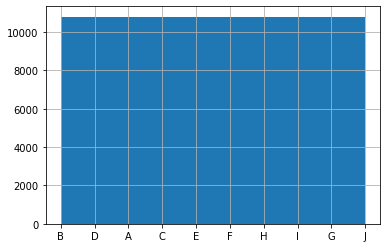

In [ ]:
y_SMOTE.hist()

In [ ]:
X_SMOTE

,FIRE_YEAR,LATITUDE,FIRE_SIZE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD,DISCOVERY_TIME
0,2017,33.006750,1.000000,95.067640,48063,3,1,0.895784,43,1301.100000
1,2006,29.863890,8.000000,83.384990,12123,5,7,0.000000,8,1420.000000
2,2017,32.084894,0.150000,82.174761,13267,3,0,0.000000,9,1527.000000
3,2003,32.942959,3.050000,81.795772,13033,1,0,0.895784,9,1238.500000
4,1995,32.795749,26.000000,89.616802,28079,4,0,0.000000,24,1410.000000
...,...,...,...,...,...,...,...,...,...,...
107995,2008,40.979903,25579.725957,117.583942,32013,7,7,2.287375,32,1780.654266
107996,2005,37.000452,88679.367164,112.360740,8630,5,5,68.663657,6,1909.661402
107997,2005,62.889557,45160.748995,159.399867,1000000,6,7,47.831246,0,1689.256989
107998,2006,37.230869,16461.612310,117.799374,5479,5,6,44.554230,3,1130.686333


In [ ]:
y_SMOTE

0         B
1         D
2         A
3         C
4         E
         ..
107995    J
107996    J
107997    J
107998    J
107999    J
Name: FIRE_SIZE_CLASS, Length: 108000, dtype: object

In [ ]:
Fires_SMOTE = pd.concat([X_SMOTE, y_SMOTE], axis=1)
Fires_SMOTE

,FIRE_YEAR,LATITUDE,FIRE_SIZE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD,DISCOVERY_TIME,FIRE_SIZE_CLASS
0,2017,33.006750,1.000000,95.067640,48063,3,1,0.895784,43,1301.100000,B
1,2006,29.863890,8.000000,83.384990,12123,5,7,0.000000,8,1420.000000,D
2,2017,32.084894,0.150000,82.174761,13267,3,0,0.000000,9,1527.000000,A
3,2003,32.942959,3.050000,81.795772,13033,1,0,0.895784,9,1238.500000,C
4,1995,32.795749,26.000000,89.616802,28079,4,0,0.000000,24,1410.000000,E
...,...,...,...,...,...,...,...,...,...,...,...
107995,2008,40.979903,25579.725957,117.583942,32013,7,7,2.287375,32,1780.654266,J
107996,2005,37.000452,88679.367164,112.360740,8630,5,5,68.663657,6,1909.661402,J
107997,2005,62.889557,45160.748995,159.399867,1000000,6,7,47.831246,0,1689.256989,J
107998,2006,37.230869,16461.612310,117.799374,5479,5,6,44.554230,3,1130.686333,J


In [ ]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_SMOTE_train = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
X_SMOTE_test = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_SMOTE_train = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y_SMOTE_test = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_SMOTE = dict()    
model_SMOTE_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_SMOTE = model().fit(X_SMOTE_train,X_SMOTE_test)
  y_SMOTE_pred = regressor_SMOTE.predict(y_SMOTE_train)
  model_SMOTE_mse = mean_squared_error(y_SMOTE_pred,y_SMOTE_test)
  model_SMOTE_mae = mean_absolute_error(y_SMOTE_pred,y_SMOTE_test)
  model_scores_SMOTE[model] = (regressor_SMOTE,y_SMOTE_test,y_SMOTE_pred)
  model_SMOTE_df = model_SMOTE_df.append({'Model':model,'MSE':model_SMOTE_mse,'MAE':model_SMOTE_mae}, ignore_index=True)
  model_SMOTE_df = model_SMOTE_df.sort_values(by='MSE', ascending= True)
model_SMOTE_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,1.413125e+06,155.025233
4,<class 'sklearn.neighbors._regression.KNeighbo...,3.612315e+06,385.162218
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.596249e+07,1730.591751
2,<class 'sklearn.linear_model._base.LinearRegre...,1.988422e+07,3358.637660
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,4.524376e+07,4448.483140
